# Main Code

In [3]:
import pandas as pd
import numpy as np
import os
import joblib
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split, GridSearchCV, RepeatedStratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import KNNImputer
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.pipeline import Pipeline

from sklearn.ensemble import (
    RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier,
    ExtraTreesClassifier, StackingClassifier, VotingClassifier
)
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis, LinearDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier

df = pd.read_csv("/content/Raw Dataset.csv")
df.columns = [col.split(". ", 1)[-1].strip() for col in df.columns]

stress_cols = df.columns[7:17]
anxiety_cols = df.columns[17:24]
depression_cols = df.columns[24:33]
selected_cols = list(stress_cols) + list(anxiety_cols) + list(depression_cols)

def convert_response(resp):
    mapping = {
        "0 - Never": 0, "1 - Almost Never": 1, "2 - Sometimes": 2,
        "3 - Fairly Often": 3, "4 - Very Often": 4,
        "0 - Not at all": 0, "1 - Several days": 1,
        "2 - More than half the days": 2, "3 - Nearly every day": 3
    }
    return mapping.get(resp, np.nan)

for col in selected_cols:
    df[col] = df[col].apply(convert_response)

imputer = KNNImputer(n_neighbors=5)
df[selected_cols] = imputer.fit_transform(df[selected_cols])

def remove_outliers(df, cols):
    Q1 = df[cols].quantile(0.25)
    Q3 = df[cols].quantile(0.75)
    IQR = Q3 - Q1
    return df[~((df[cols] < (Q1 - 1.5 * IQR)) | (df[cols] > (Q3 + 1.5 * IQR))).any(axis=1)]

df = remove_outliers(df, selected_cols)

df["Stress_Score"] = df[stress_cols].sum(axis=1)
df["Anxiety_Score"] = df[anxiety_cols].sum(axis=1)
df["Depression_Score"] = df[depression_cols].sum(axis=1)

def classify(score, mild, moderate):
    if score <= mild: return "Low"
    elif score <= moderate: return "Moderate"
    else: return "Severe"

df["Stress_Level"] = df["Stress_Score"].apply(lambda x: classify(x, 13, 26))
df["Anxiety_Level"] = df["Anxiety_Score"].apply(lambda x: classify(x, 7, 14))
df["Depression_Level"] = df["Depression_Score"].apply(lambda x: classify(x, 9, 18))

X = df[selected_cols]
y = df[["Stress_Level", "Anxiety_Level", "Depression_Level"]]

os.makedirs("models/cv_models", exist_ok=True)

models = [
    ("Random Forest", RandomForestClassifier(n_estimators=100, random_state=42)),
    ("Logistic Regression", LogisticRegression(max_iter=1000, random_state=42)),
    ("KNN", KNeighborsClassifier()),
    ("SVM", SVC(probability=True, random_state=42)),
    ("Decision Tree", DecisionTreeClassifier(random_state=42)),
    ("Gradient Boosting", GradientBoostingClassifier(random_state=42)),
    ("AdaBoost", AdaBoostClassifier(random_state=42)),
    ("Naive Bayes", GaussianNB()),
    ("Extra Trees", ExtraTreesClassifier(random_state=42)),
    ("QDA", QuadraticDiscriminantAnalysis()),
    ("LDA", LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto')),
    ("Ridge Classifier", RidgeClassifier(alpha=1))
]

# Stratified K-Fold Cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

label_encoders = {label: LabelEncoder().fit(y[label]) for label in y.columns}

# Loop through each label (target)
for label in y.columns:
    print(f"\nProcessing target: {label}")

    le = label_encoders[label]
    y_encoded = le.transform(y[label])

    selector = SelectKBest(f_classif, k=15)
    X_selected = selector.fit_transform(X, y_encoded)

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_selected)

    # PCA
    pca = PCA(n_components=0.95)
    X_pca = pca.fit_transform(X_scaled)

    # SMOTE + ENN Resampling (via Pipeline)
    smote = SMOTE(random_state=42)
    enn = EditedNearestNeighbours(n_neighbors=3)
    resampling_pipeline = Pipeline(steps=[('smote', smote), ('enn', enn)])

    X_resampled, y_resampled = resampling_pipeline.fit_resample(X_pca, y_encoded)

    X_train, X_val, y_train, y_val = train_test_split(
        X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
    )

    # Hyperparameter tuning for Random Forest
    param_grid_rf = {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2]
    }
    grid_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_rf, cv=3, n_jobs=-1, verbose=2)
    grid_rf.fit(X_train, y_train)
    print(f"Best Random Forest Hyperparameters: {grid_rf.best_params_}")
    print(f"Best Random Forest Accuracy: {grid_rf.best_score_}")

    # stacking classifier
    base_learners = [
        ('rf', RandomForestClassifier(n_estimators=200, random_state=42)),
        ('svc', SVC(probability=True, random_state=42)),
        ('mlp', MLPClassifier(hidden_layer_sizes=(256, 128, 64), activation='relu', solver='adam',
                   alpha=0.0001, max_iter=500, learning_rate_init=0.001, random_state=42)),
        ('gb', GradientBoostingClassifier(random_state=42)),
        ('ada', AdaBoostClassifier(random_state=42))
    ]
    meta_learner = LogisticRegression()
    stacking_clf = StackingClassifier(estimators=base_learners, final_estimator=meta_learner)

    stacking_clf.fit(X_train, y_train)
    stacking_acc = stacking_clf.score(X_val, y_val)
    print(f"Stacking Classifier (with more models) | Accuracy: {stacking_acc:.4f}")
    joblib.dump(stacking_clf, f"models/cv_models/{label}_StackingClassifier.pkl")

    # Voting ensemble
    ensemble = VotingClassifier(estimators=[
        ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
        ('svc', SVC(probability=True, random_state=42)),
        ('mlp', MLPClassifier(hidden_layer_sizes=(256, 128, 64), activation='relu', solver='adam',
                   alpha=0.0001, max_iter=500, learning_rate_init=0.001, random_state=42))
    ], voting='soft')

    ensemble.fit(X_train, y_train)
    ensemble_acc = ensemble.score(X_val, y_val)
    print(f"Voting Ensemble | Accuracy: {ensemble_acc:.4f}")
    joblib.dump(ensemble, f"models/cv_models/{label}_VotingEnsemble.pkl")

    # Cross-validation with Repeated Stratified K-Fold
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)
    scores = cross_val_score(stacking_clf, X_resampled, y_resampled, cv=cv, n_jobs=-1, scoring='accuracy')
    print(f"Stacking Classifier | Cross-validated accuracy: {np.mean(scores):.4f} ± {np.std(scores):.4f}")



Processing target: Stress_Level
Fitting 3 folds for each of 36 candidates, totalling 108 fits


<ipython-input-3-bbcb27f111e2>:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Stress_Score"] = df[stress_cols].sum(axis=1)
<ipython-input-3-bbcb27f111e2>:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Anxiety_Score"] = df[anxiety_cols].sum(axis=1)
<ipython-input-3-bbcb27f111e2>:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

Best Random Forest Hyperparameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best Random Forest Accuracy: 0.9841214699279215
Stacking Classifier (with more models) | Accuracy: 0.9918
Voting Ensemble | Accuracy: 0.9898
Stacking Classifier | Cross-validated accuracy: 0.9917 ± 0.0041

Processing target: Anxiety_Level
Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best Random Forest Hyperparameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best Random Forest Accuracy: 0.9731046227321594
Stacking Classifier (with more models) | Accuracy: 1.0000
Voting Ensemble | Accuracy: 0.9971
Stacking Classifier | Cross-validated accuracy: 0.9950 ± 0.0049

Processing target: Depression_Level
Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best Random Forest Hyperparameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Best Random Forest Accu

# Correlation Matrix

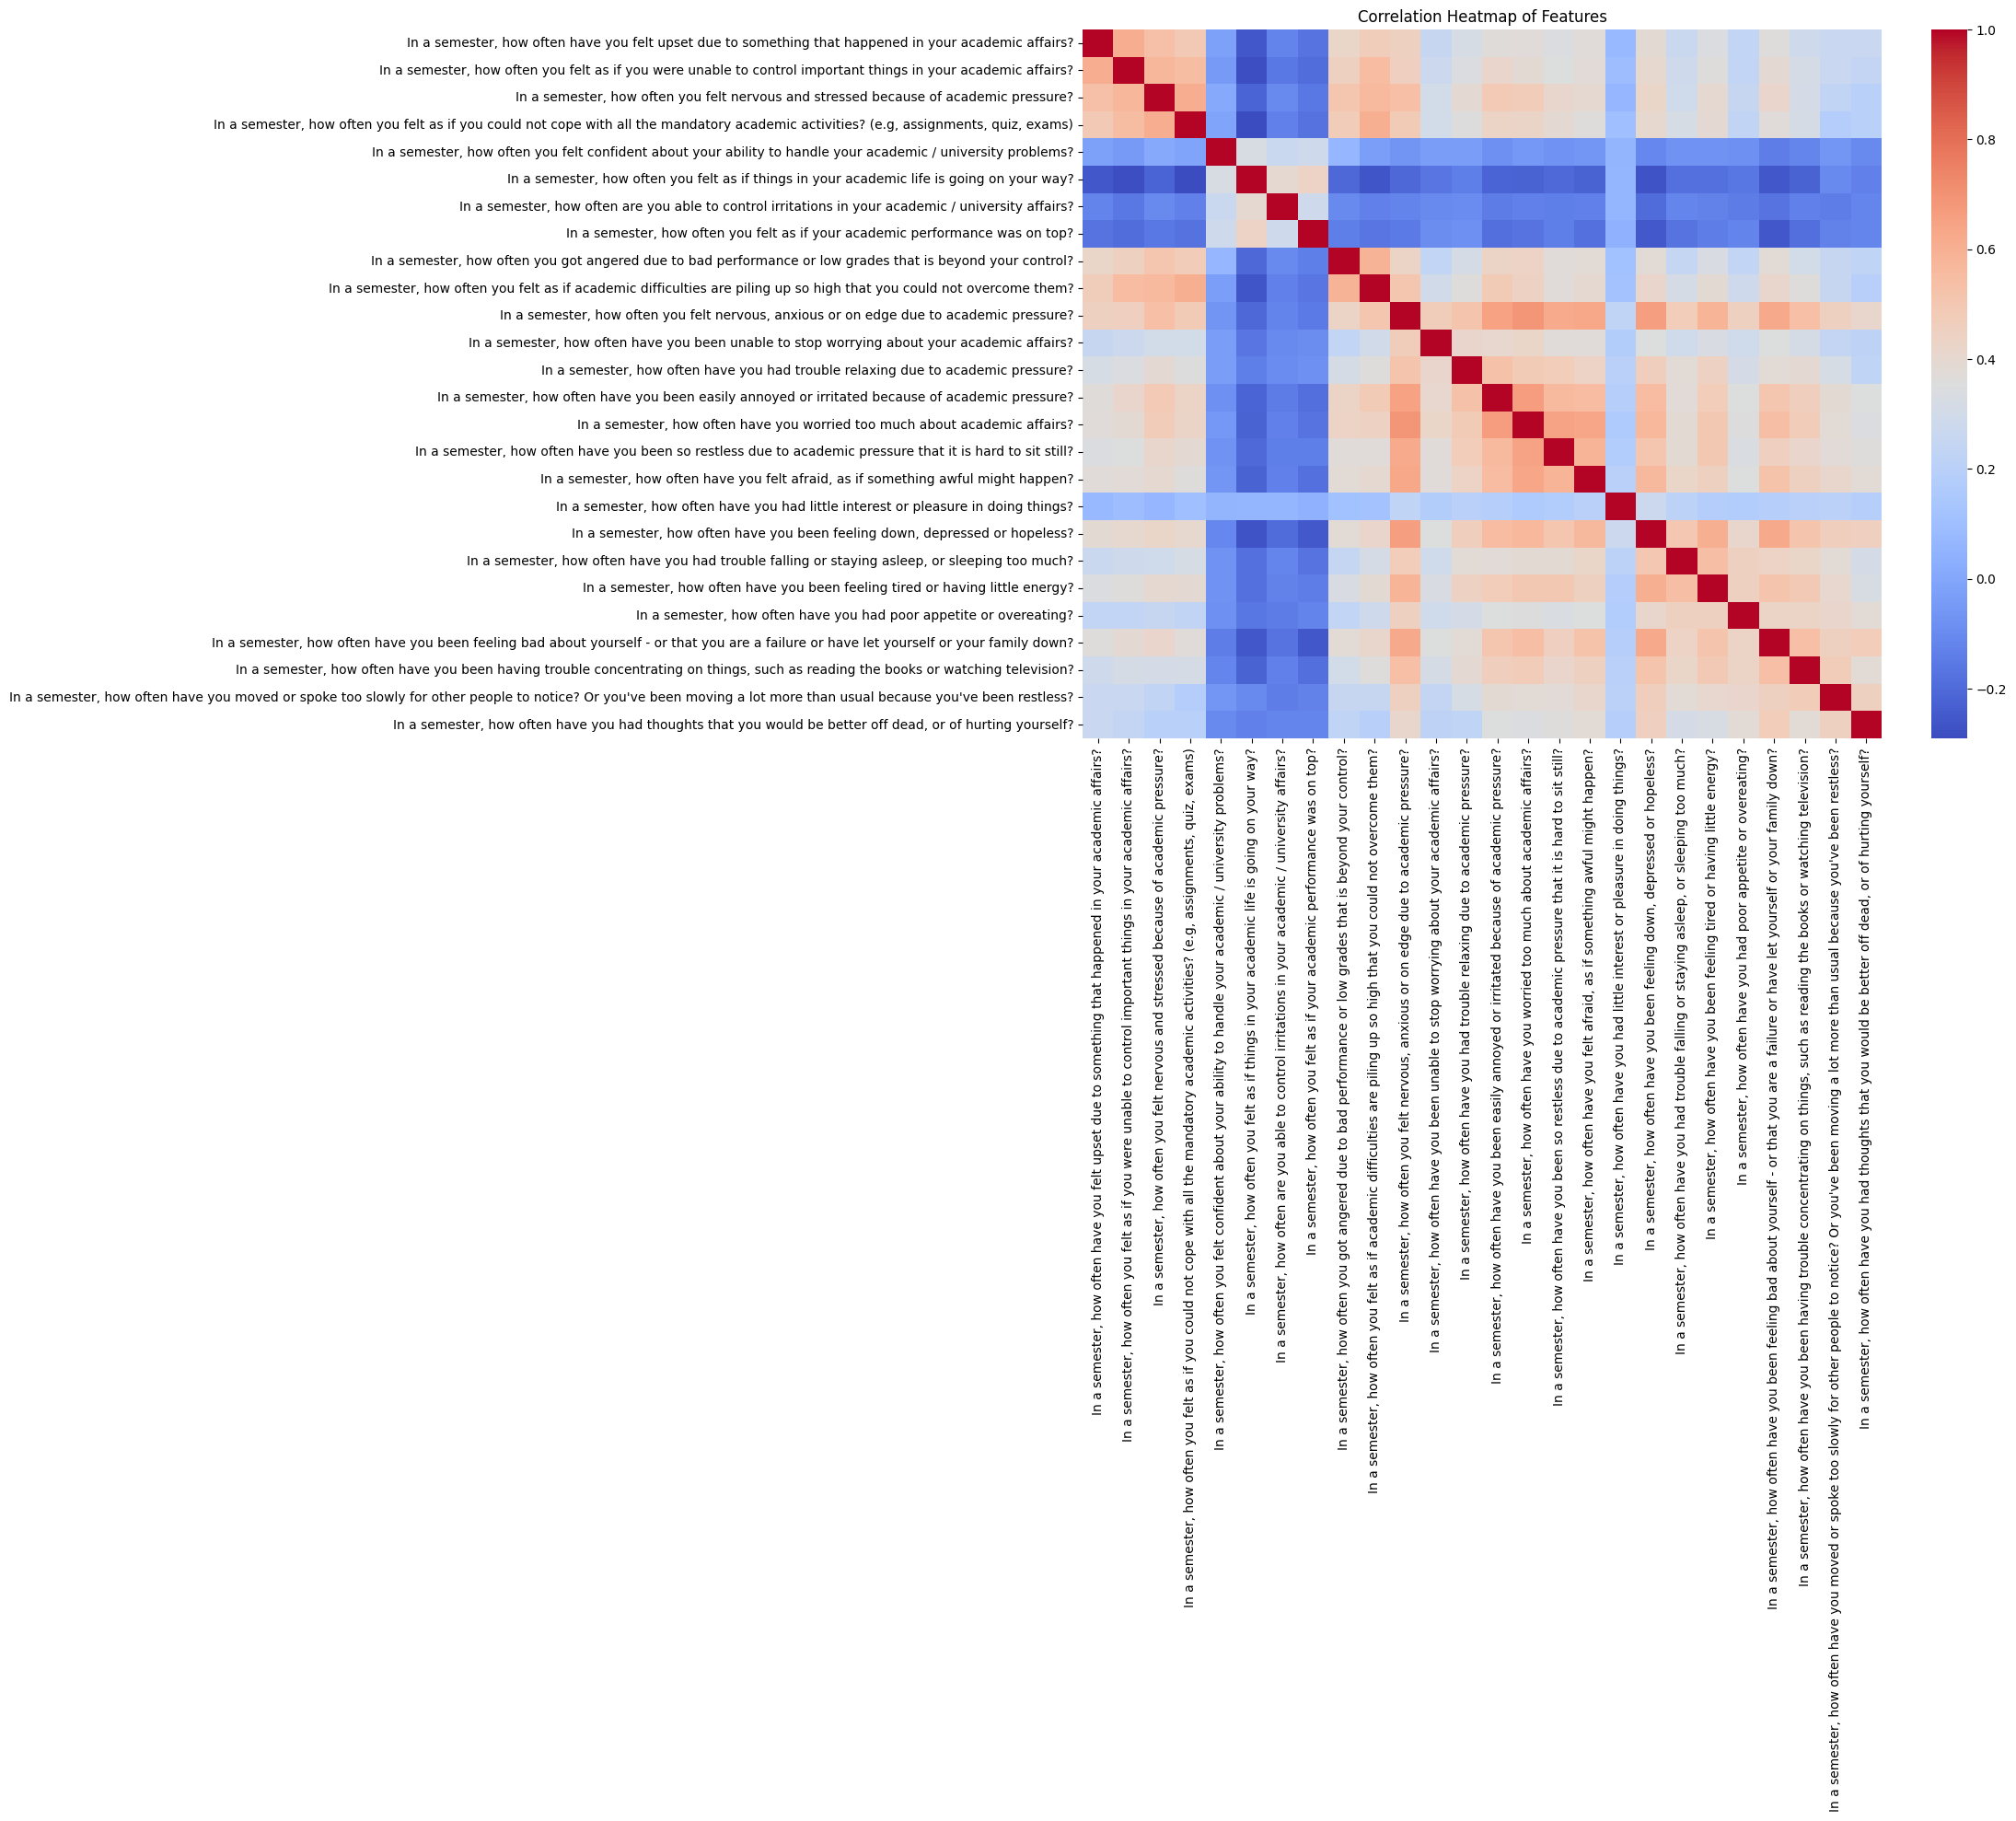

Dropped highly correlated features: []


In [9]:
corr_matrix = pd.DataFrame(X, columns=selected_cols).corr()
plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=False)
plt.title("Correlation Heatmap of Features")
plt.show()


upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.9)]
X = X.drop(columns=to_drop)
print(f"Dropped highly correlated features: {to_drop}")


# SMOTE-ENN Visualization Code befor and after


Processing: Stress_Level


<ipython-input-8-11ef27444a15>:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=classes, y=count_before.values, ax=axes[0], palette="pastel")
<ipython-input-8-11ef27444a15>:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=classes, y=count_after.values, ax=axes[1], palette="Set2")


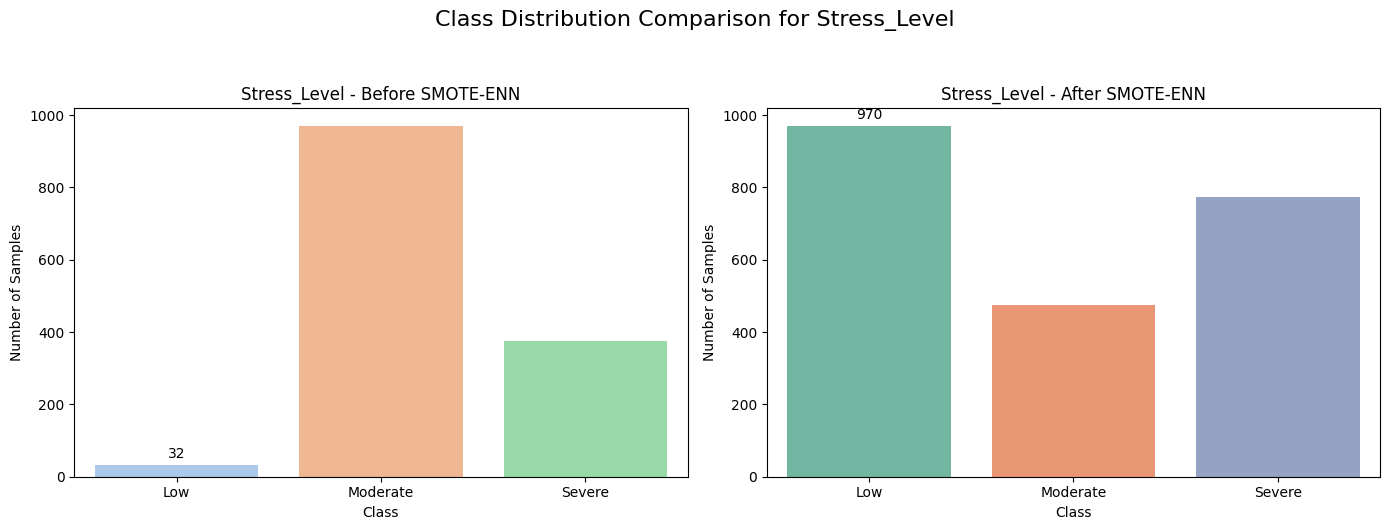


Processing: Anxiety_Level


<ipython-input-8-11ef27444a15>:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=classes, y=count_before.values, ax=axes[0], palette="pastel")
<ipython-input-8-11ef27444a15>:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=classes, y=count_after.values, ax=axes[1], palette="Set2")


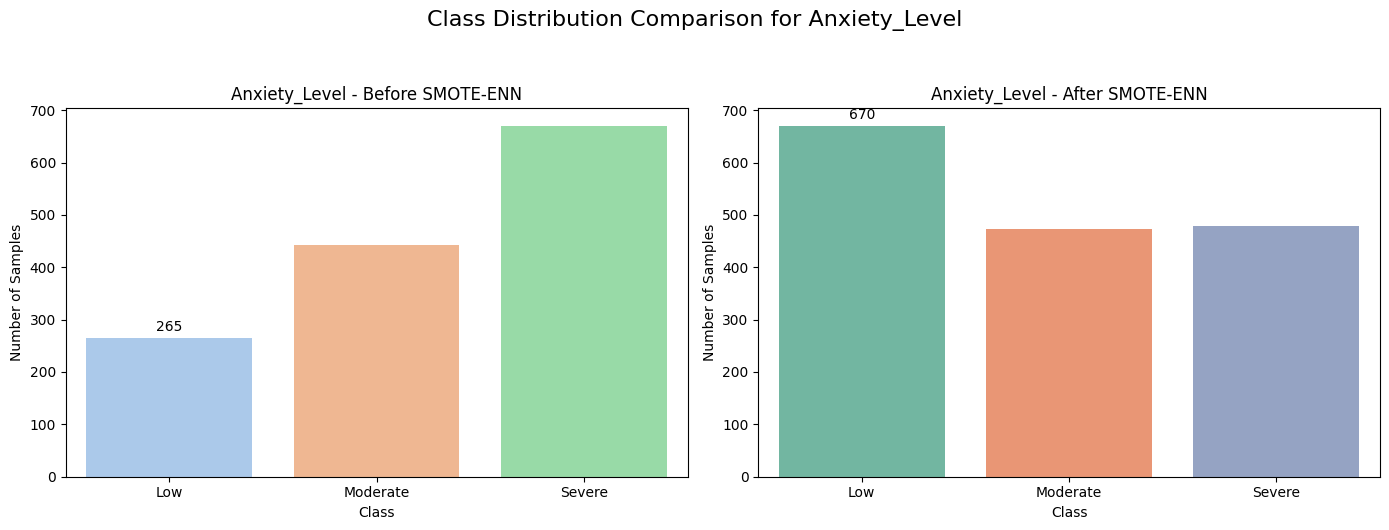


Processing: Depression_Level


<ipython-input-8-11ef27444a15>:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=classes, y=count_before.values, ax=axes[0], palette="pastel")
<ipython-input-8-11ef27444a15>:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=classes, y=count_after.values, ax=axes[1], palette="Set2")


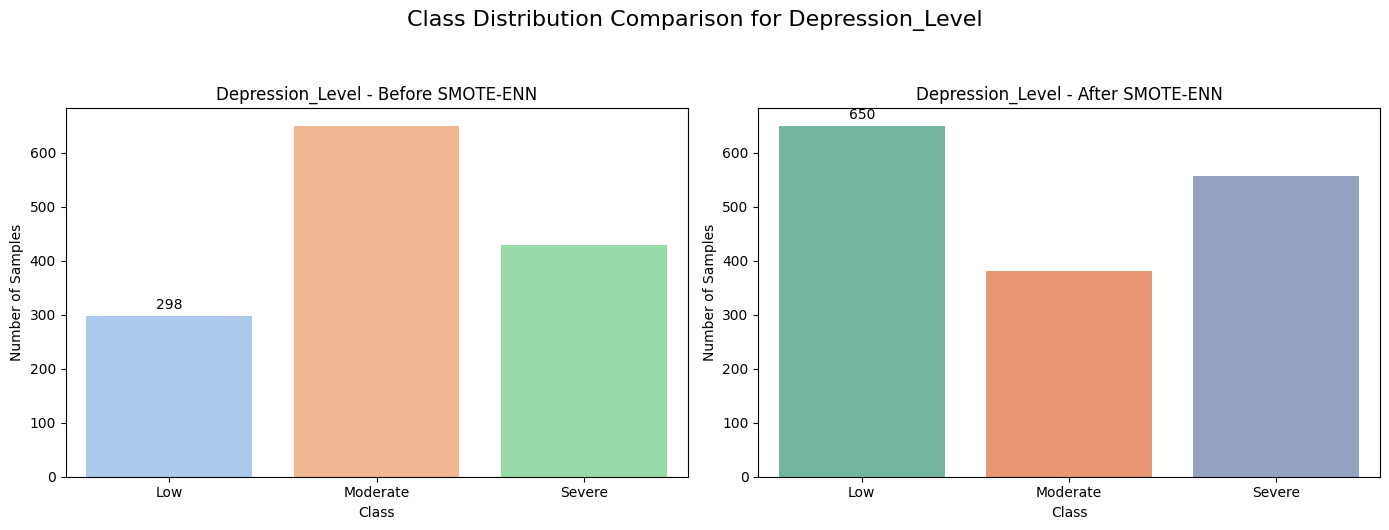

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from collections import Counter

def plot_class_distribution(y_before, y_after, label_encoder, target_name):

    # Decode if label-encoded
    if isinstance(y_before[0], (int, np.integer)):
        y_before = label_encoder.inverse_transform(y_before)
        y_after = label_encoder.inverse_transform(y_after)

    count_before = pd.Series(y_before).value_counts().sort_index()
    count_after = pd.Series(y_after).value_counts().sort_index()

    # Align classes
    classes = sorted(set(count_before.index).union(set(count_after.index)))

    count_before = count_before.reindex(classes, fill_value=0)
    count_after = count_after.reindex(classes, fill_value=0)

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    sns.barplot(x=classes, y=count_before.values, ax=axes[0], palette="pastel")
    axes[0].set_title(f'{target_name} - Before SMOTE-ENN')
    axes[0].set_ylabel('Number of Samples')
    axes[0].set_xlabel('Class')
    axes[0].bar_label(axes[0].containers[0], fmt='%d', padding=3)

    sns.barplot(x=classes, y=count_after.values, ax=axes[1], palette="Set2")
    axes[1].set_title(f'{target_name} - After SMOTE-ENN')
    axes[1].set_ylabel('Number of Samples')
    axes[1].set_xlabel('Class')
    axes[1].bar_label(axes[1].containers[0], fmt='%d', padding=3)

    plt.suptitle(f"Class Distribution Comparison for {target_name}", fontsize=16, y=1.05)
    plt.tight_layout()
    plt.show()


from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.pipeline import Pipeline

smote = SMOTE(random_state=42)
enn = EditedNearestNeighbours(n_neighbors=3)
resampling_pipeline = Pipeline(steps=[('smote', smote), ('enn', enn)])

for label in y.columns:
    print(f"\nProcessing: {label}")

    le = label_encoders[label]
    y_encoded = le.transform(y[label])

    # PCA or other preprocessing before resampling
    X_resampled, y_resampled = resampling_pipeline.fit_resample(X_pca, y_encoded)

    plot_class_distribution(y_encoded, y_resampled, le, label)


# PCA Visualization


🔍 PCA Visualization for: Stress_Level


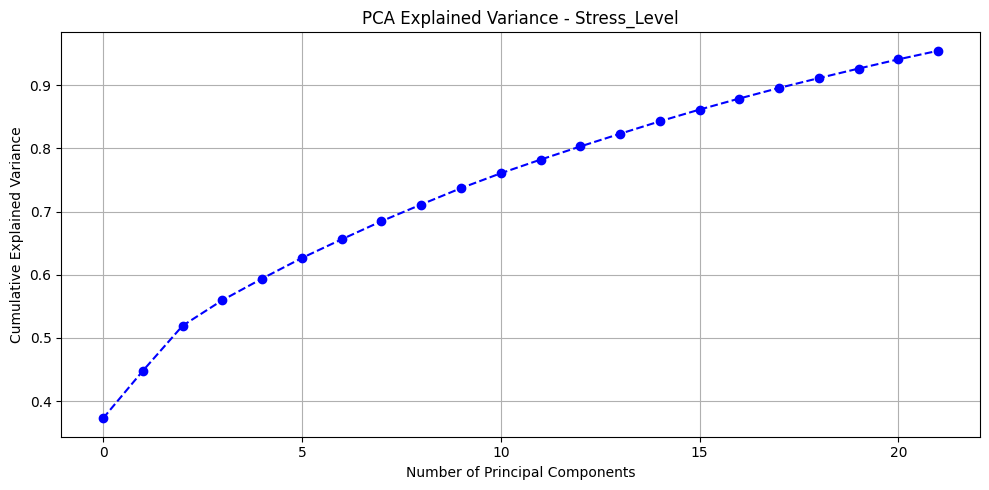

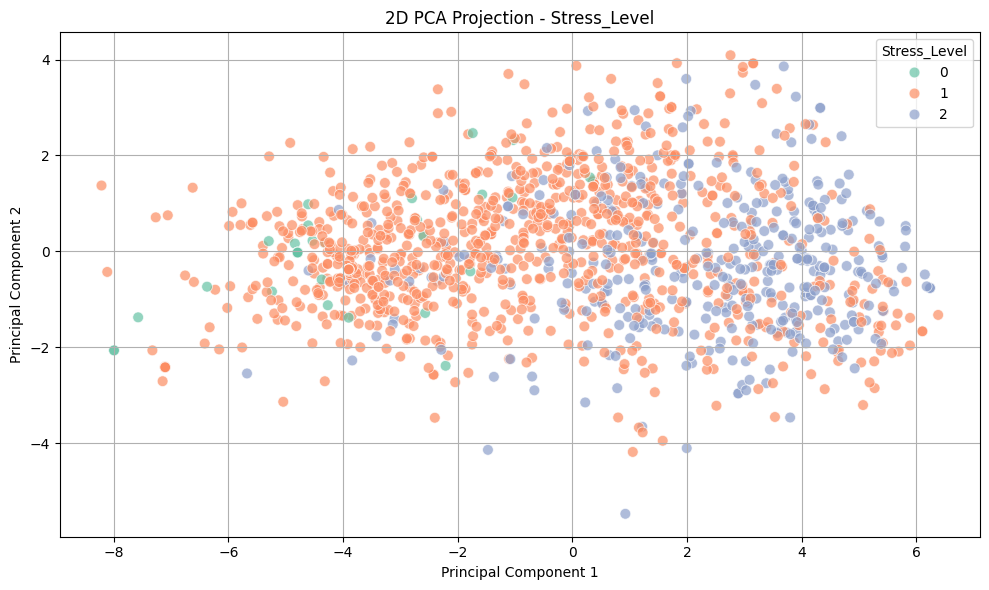


🔍 PCA Visualization for: Anxiety_Level


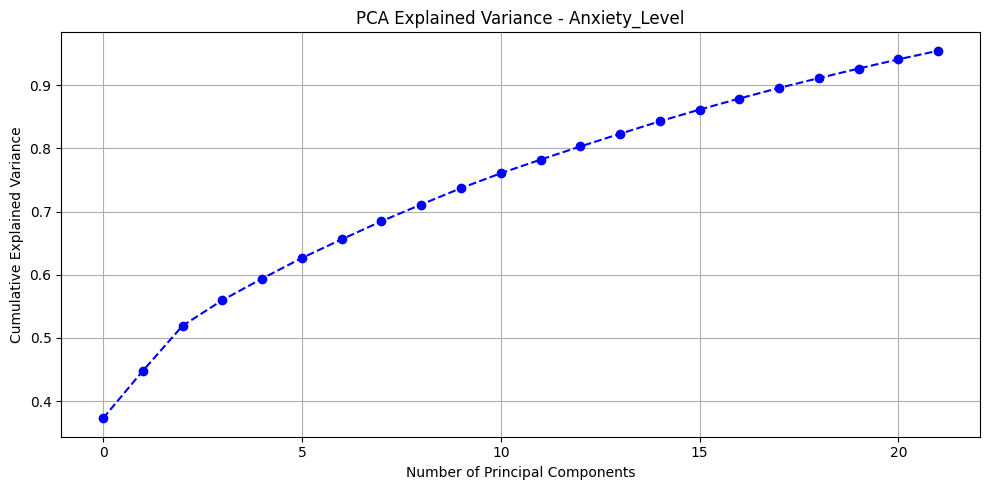

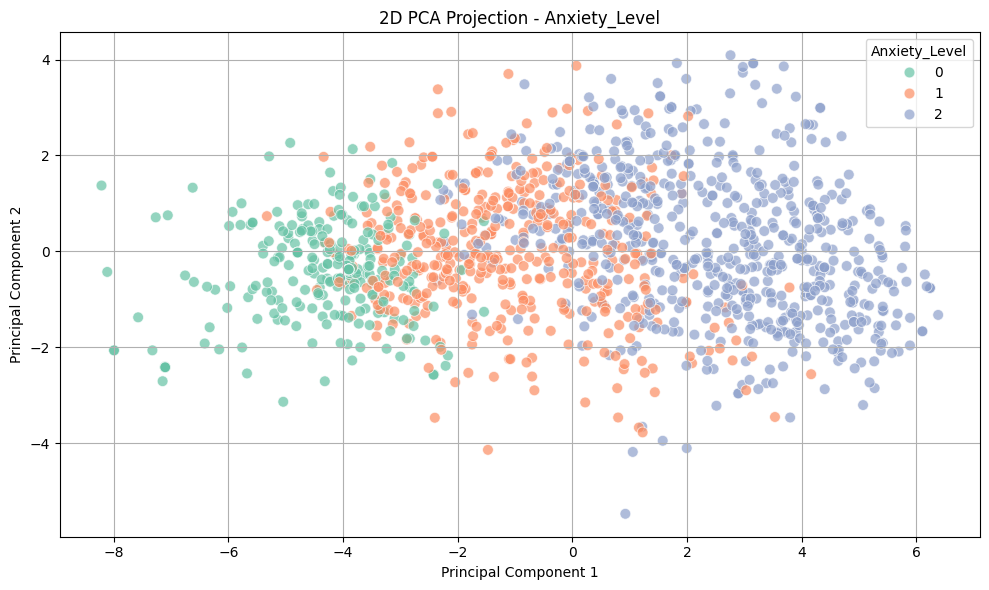


🔍 PCA Visualization for: Depression_Level


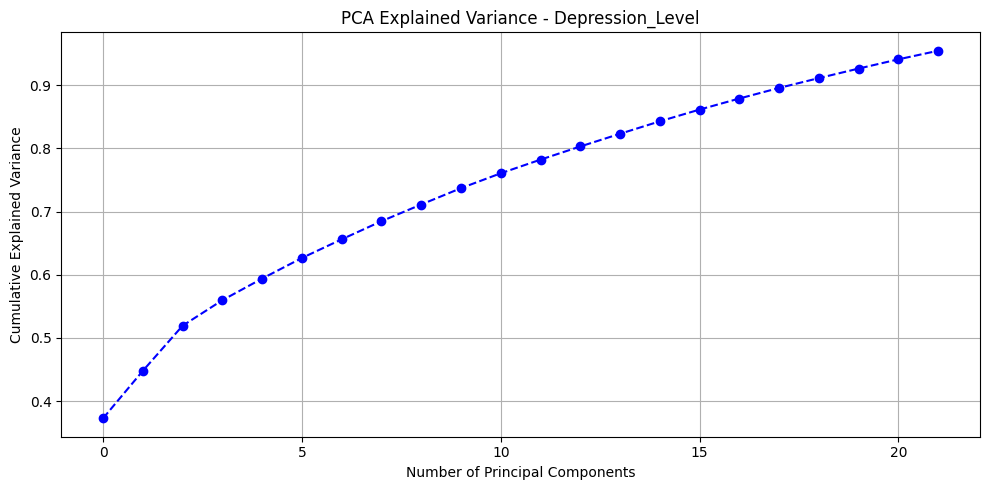

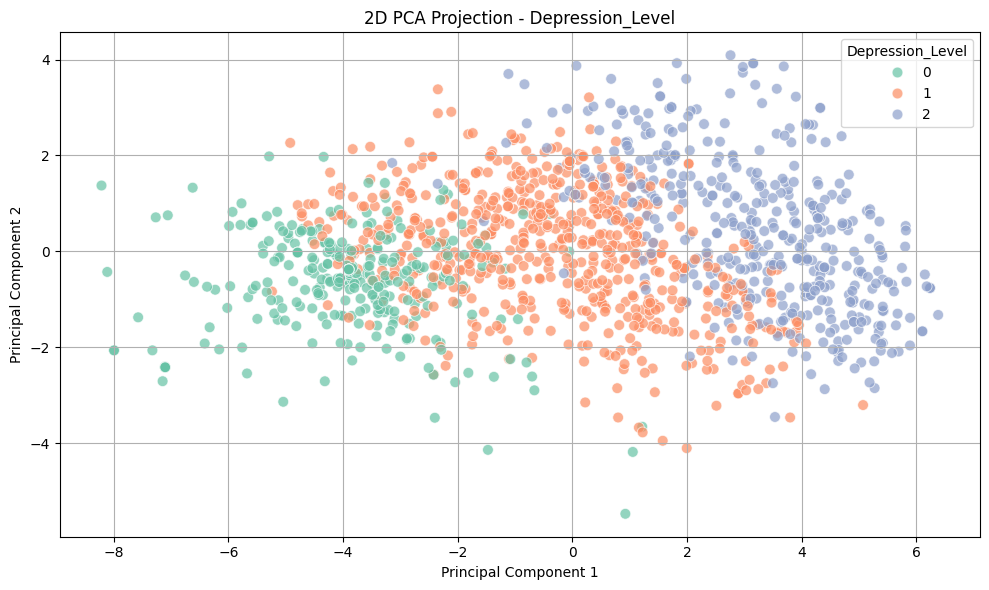

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA

def visualize_pca_for_label(X, y, label_name="Label", n_components=0.95):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X_scaled)

    plt.figure(figsize=(10, 5))
    plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='--', color='blue')
    plt.xlabel('Number of Principal Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title(f'PCA Explained Variance - {label_name}')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # 2D Projection Plot
    if X_pca.shape[1] >= 2:
        plt.figure(figsize=(10, 6))
        sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y, palette='Set2', alpha=0.7, s=60)
        plt.xlabel('Principal Component 1')
        plt.ylabel('Principal Component 2')
        plt.title(f'2D PCA Projection - {label_name}')
        plt.legend(title=label_name)
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    return X_pca, pca

label_encoders = {label: LabelEncoder().fit(y[label]) for label in y.columns}

for label in y.columns:
    print(f"\n🔍 PCA Visualization for: {label}")

    le = label_encoders[label]
    y_encoded = le.transform(y[label])

    X_pca, pca_model = visualize_pca_for_label(X, y_encoded, label_name=label, n_components=0.95)


# ROC curves MLP

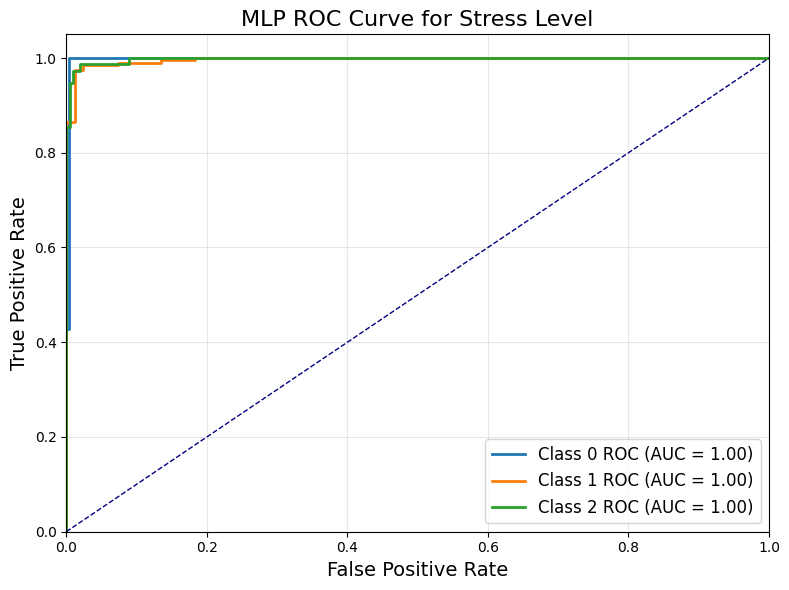

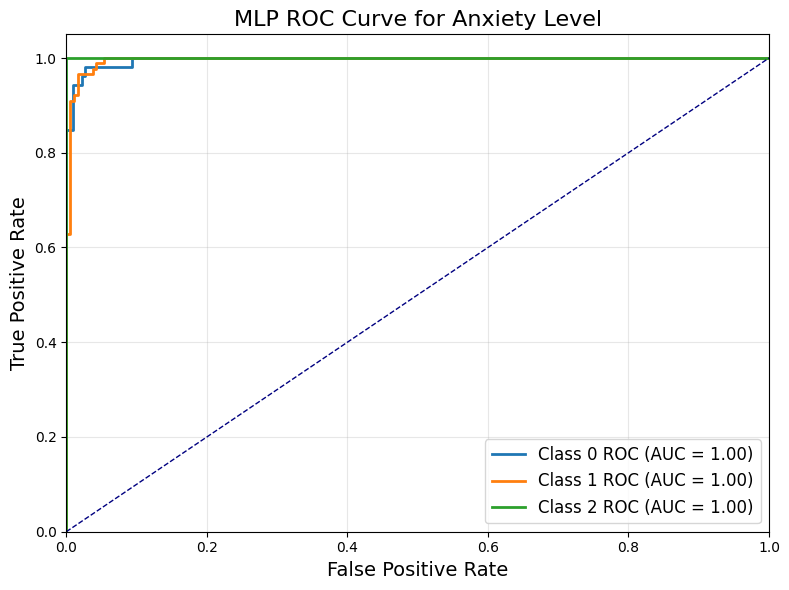

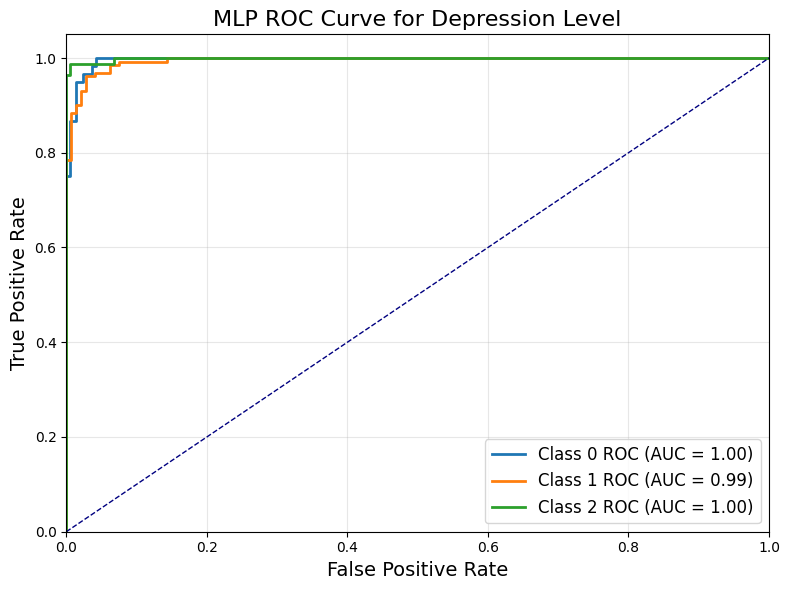

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize, StandardScaler
from sklearn.model_selection import train_test_split

def run_mlp_and_plot_roc(X, y, target_name, test_size=0.2, random_state=42):

    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)

    # Binarize labels for ROC computation
    classes = np.unique(y)
    y_train_bin = label_binarize(y_train, classes=classes)
    y_val_bin = label_binarize(y_val, classes=classes)
    n_classes = len(classes)

    # Define and train MLP
    mlp = MLPClassifier(hidden_layer_sizes=(256, 128, 64), max_iter=500, random_state=random_state)
    mlp.fit(X_train_scaled, y_train)

    # Predict probabilities on validation set
    y_score = mlp.predict_proba(X_val_scaled)

    plt.figure(figsize=(8, 6))

    if n_classes == 2:
        # Binary classification ROC
        fpr, tpr, _ = roc_curve(y_val_bin.ravel(), y_score[:, 1])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    else:
        # Multi-class ROC
        for i in range(n_classes):
            fpr, tpr, _ = roc_curve(y_val_bin[:, i], y_score[:, i])
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, lw=2, label=f'Class {classes[i]} ROC (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.title(f'MLP ROC Curve for {target_name}', fontsize=16)
    plt.legend(loc='lower right', fontsize=12)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    return mlp


from sklearn.preprocessing import LabelEncoder


le_stress = LabelEncoder()
y_encoded_stress = le_stress.fit_transform(df['Stress_Level'])

le_anxiety = LabelEncoder()
y_encoded_anxiety = le_anxiety.fit_transform(df['Anxiety_Level'])

le_depression = LabelEncoder()
y_encoded_depression = le_depression.fit_transform(df['Depression_Level'])

mlp_model_stress = run_mlp_and_plot_roc(X, y_encoded_stress, target_name="Stress Level")
mlp_model_anxiety = run_mlp_and_plot_roc(X, y_encoded_anxiety, target_name="Anxiety Level")
mlp_model_depression = run_mlp_and_plot_roc(X, y_encoded_depression, target_name="Depression Level")


# Random Forest feature importance

<ipython-input-14-c55670f77102>:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


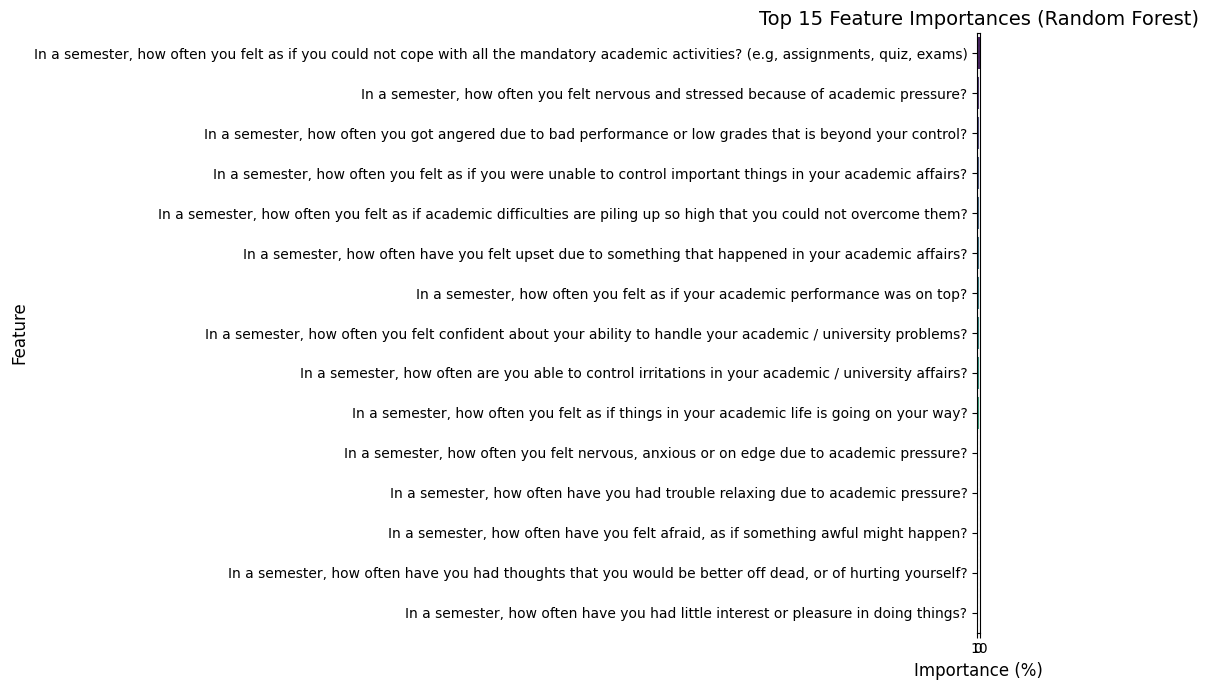

<ipython-input-14-c55670f77102>:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df.head(15), y='Feature', x='Importance (%)', palette='magma')


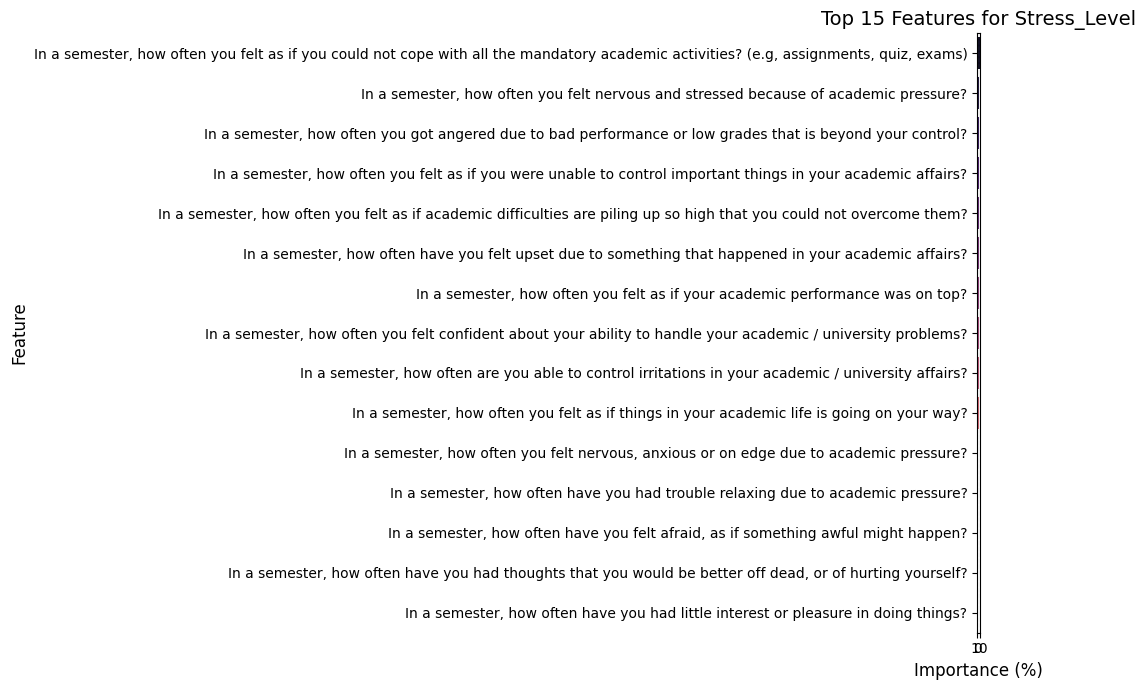

<ipython-input-14-c55670f77102>:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df.head(15), y='Feature', x='Importance (%)', palette='magma')
<ipython-input-14-c55670f77102>:65: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


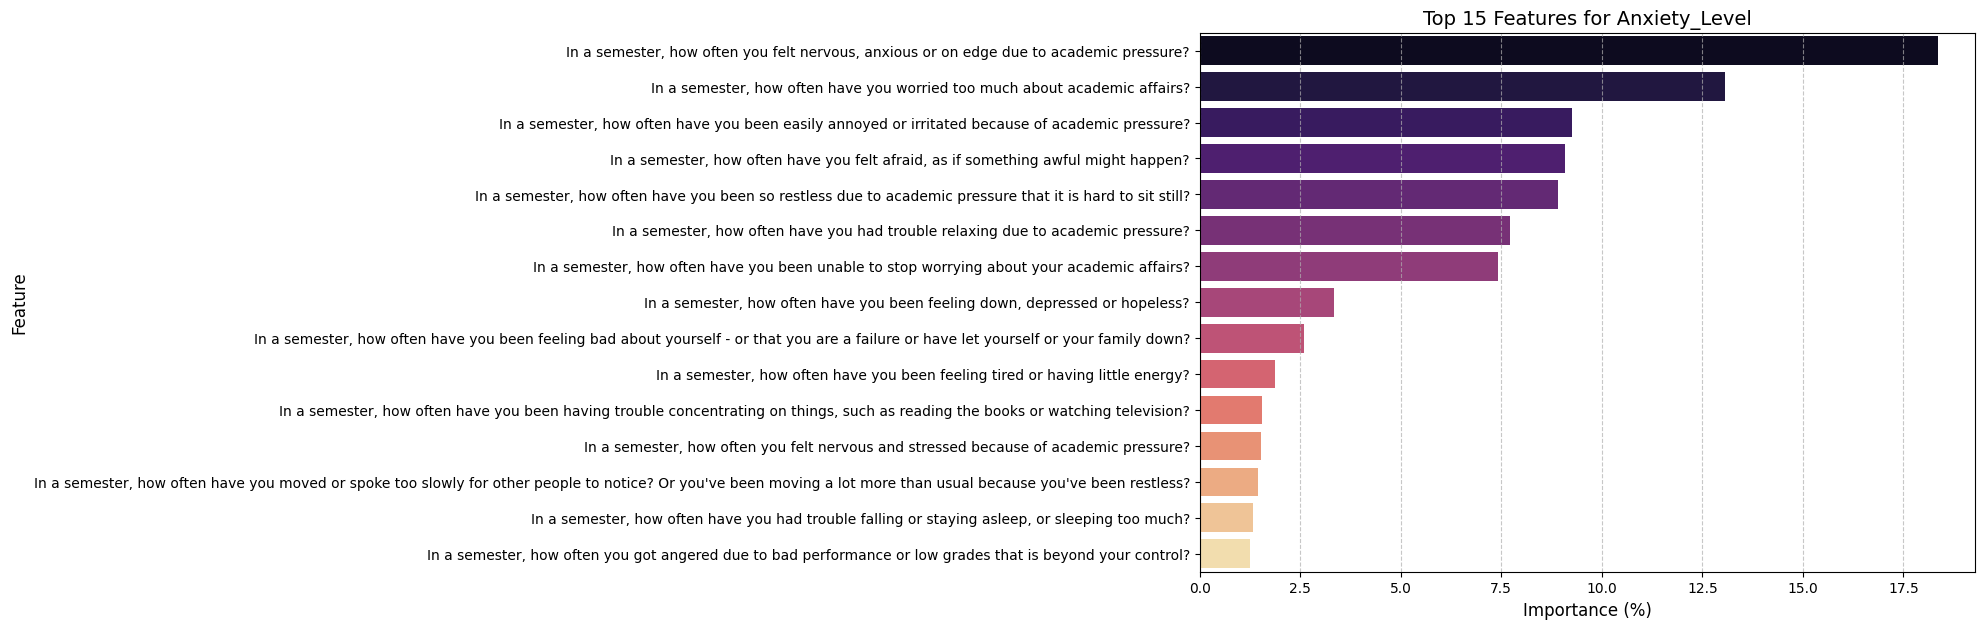

<ipython-input-14-c55670f77102>:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df.head(15), y='Feature', x='Importance (%)', palette='magma')
<ipython-input-14-c55670f77102>:65: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


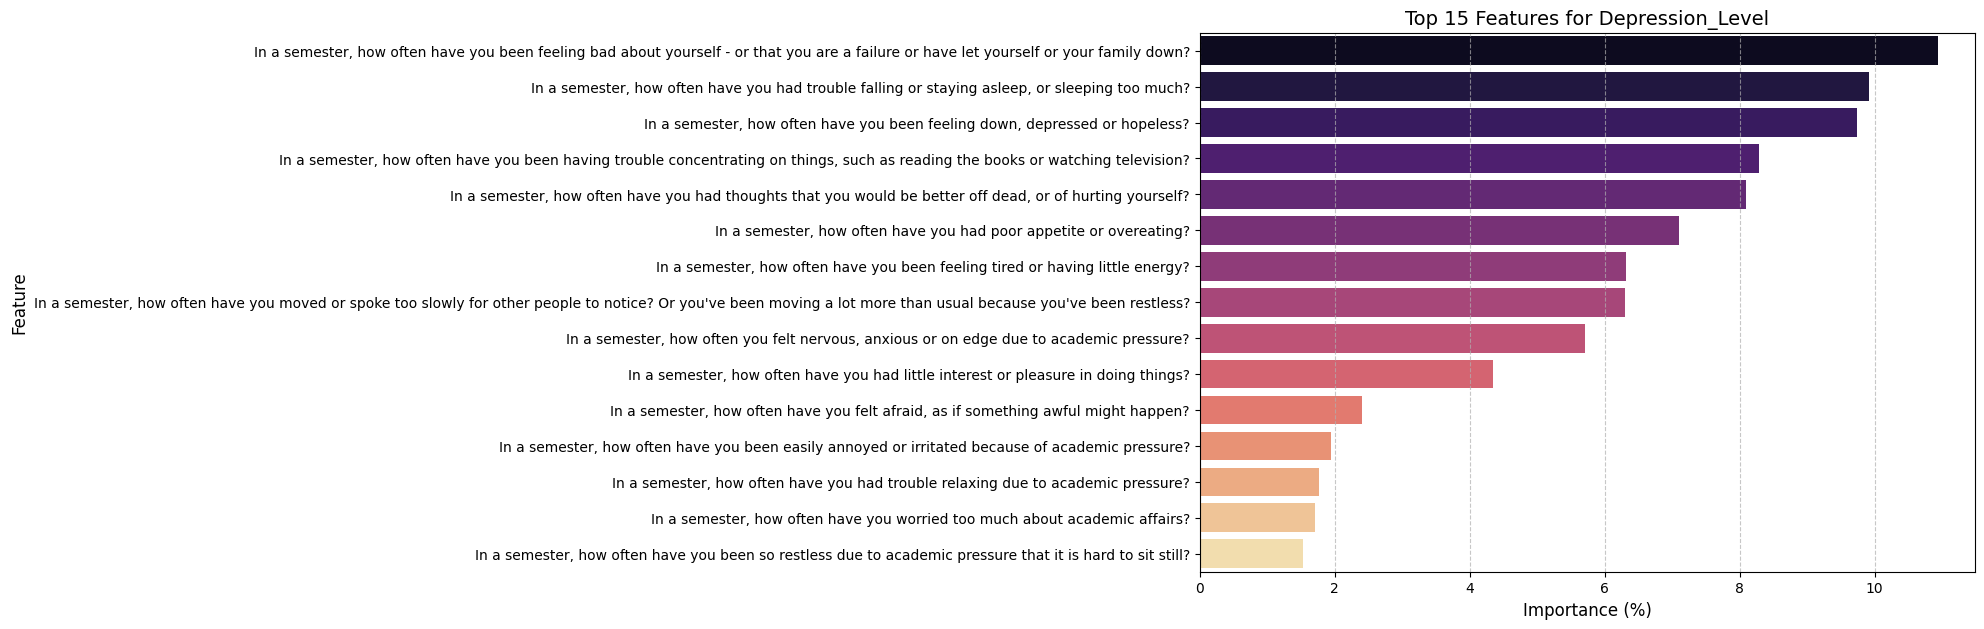

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

X = df[selected_cols]
y = df["Stress_Level"]

le = LabelEncoder()
y_encoded = le.fit_transform(y)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train Random Forest
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_scaled, y_encoded)

# Get Feature Importances
importances = rf.feature_importances_
feature_names = selected_cols
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Sort and Normalize to Percentage
importance_df = importance_df.sort_values(by='Importance', ascending=False)
importance_df['Importance (%)'] = 100 * importance_df['Importance'] / importance_df['Importance'].sum()

# Plot Top 15 Features
plt.figure(figsize=(10, 7))
sns.barplot(
    data=importance_df.head(15),
    y='Feature',
    x='Importance (%)',
    palette='viridis'
)
plt.title("Top 15 Feature Importances (Random Forest)", fontsize=14)
plt.xlabel("Importance (%)", fontsize=12)
plt.ylabel("Feature", fontsize=12)
plt.grid(True, axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


for label in ["Stress_Level", "Anxiety_Level", "Depression_Level"]:
    y = df[label]
    y_encoded = LabelEncoder().fit_transform(y)
    rf = RandomForestClassifier(n_estimators=200, random_state=42)
    rf.fit(X_scaled, y_encoded)

    importances = rf.feature_importances_
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)

    importance_df['Importance (%)'] = 100 * importance_df['Importance'] / importance_df['Importance'].sum()

    plt.figure(figsize=(10, 7))
    sns.barplot(data=importance_df.head(15), y='Feature', x='Importance (%)', palette='magma')
    plt.title(f"Top 15 Features for {label}", fontsize=14)
    plt.xlabel("Importance (%)", fontsize=12)
    plt.ylabel("Feature", fontsize=12)
    plt.grid(True, axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig(f"{label}_feature_importance.png", dpi=300)
    plt.show()

    importance_df.to_csv(f"{label}_feature_importance.csv", index=False)


# Random Forest feature importance (Number %)

<ipython-input-15-d3a97e6a2c21>:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(
<ipython-input-15-d3a97e6a2c21>:53: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


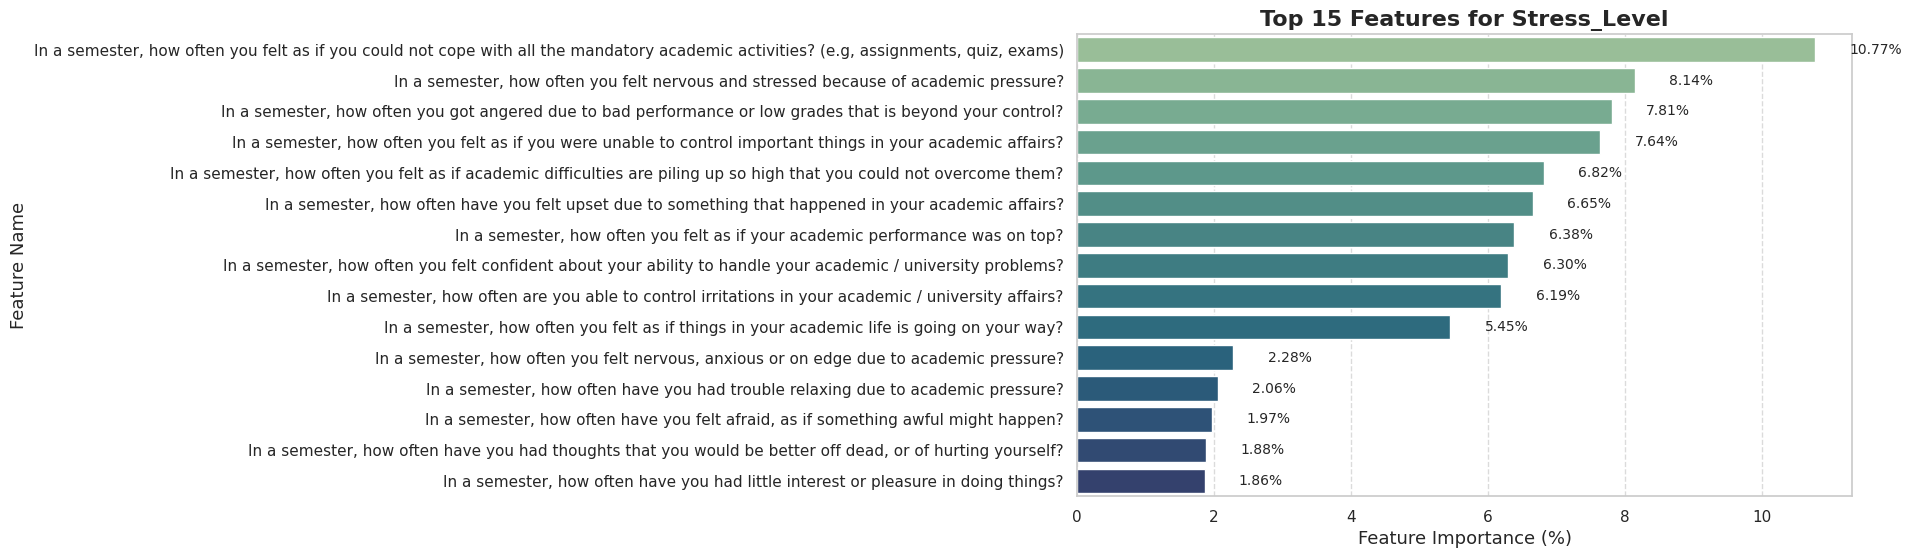

<ipython-input-15-d3a97e6a2c21>:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(
<ipython-input-15-d3a97e6a2c21>:53: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


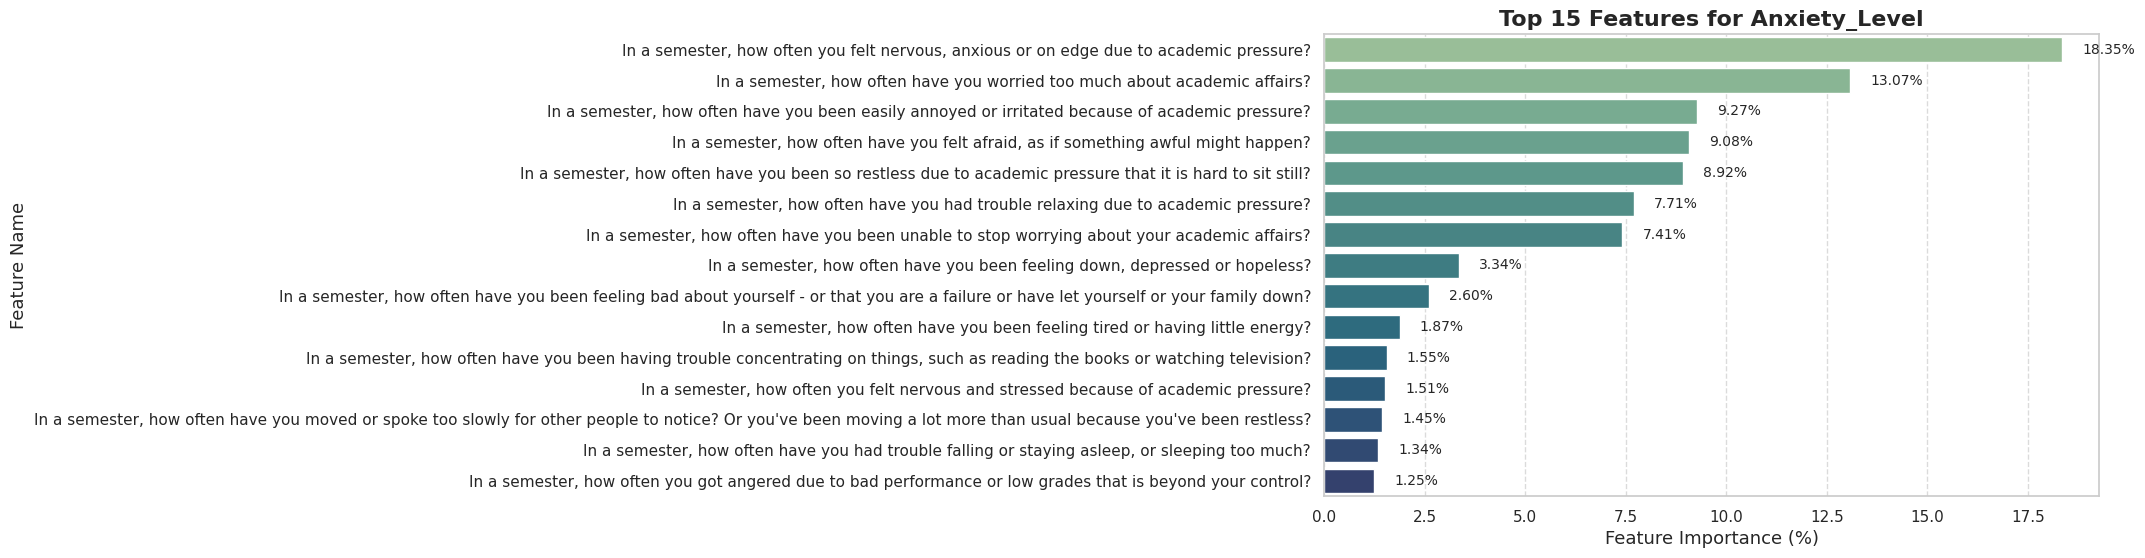

<ipython-input-15-d3a97e6a2c21>:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(
<ipython-input-15-d3a97e6a2c21>:53: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


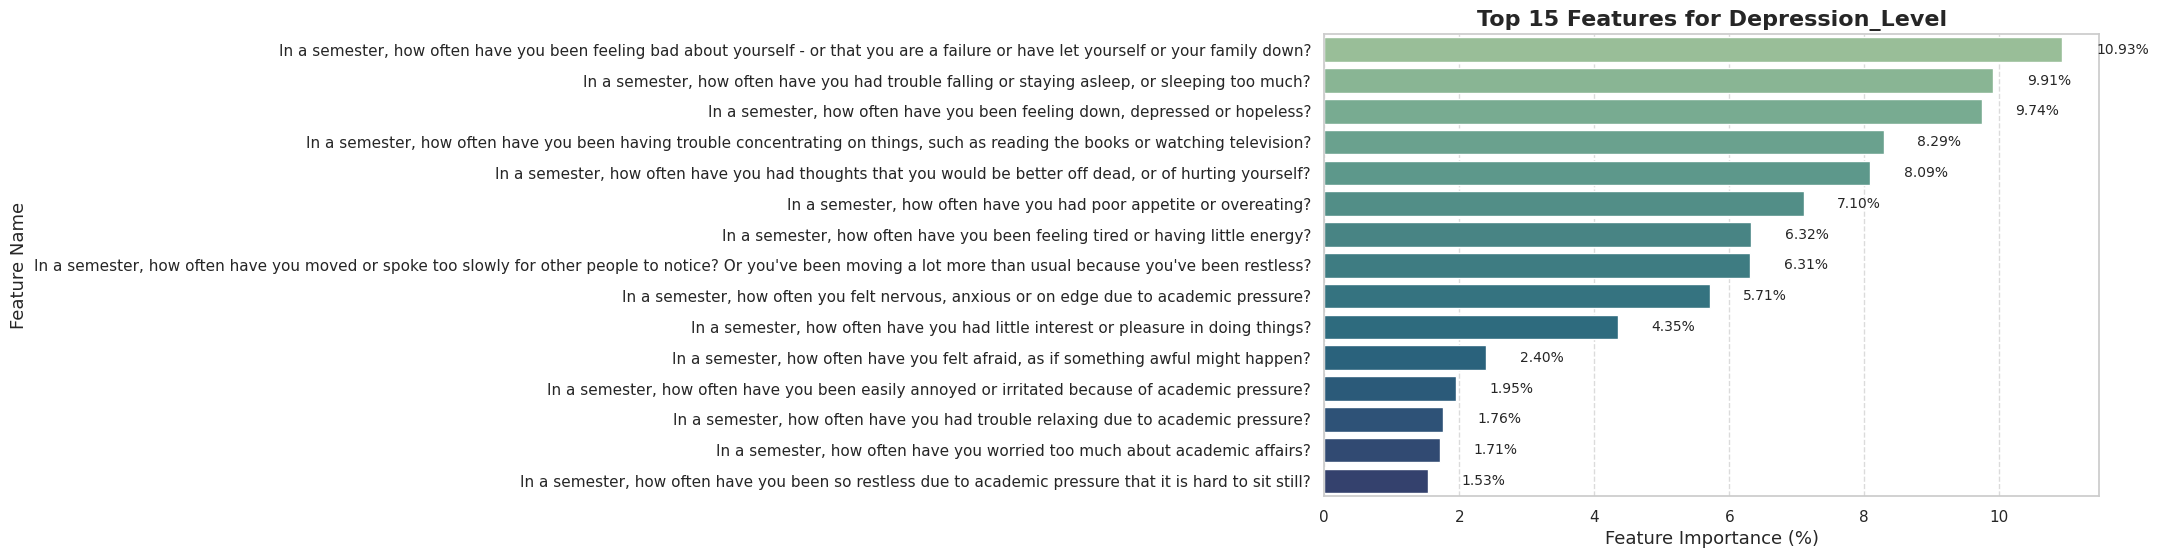

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

sns.set(style="whitegrid")

X = df[selected_cols]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
feature_names = selected_cols

for label in ["Stress_Level", "Anxiety_Level", "Depression_Level"]:
    y = df[label]
    y_encoded = LabelEncoder().fit_transform(y)

    # Train Random Forest
    rf = RandomForestClassifier(n_estimators=200, random_state=42)
    rf.fit(X_scaled, y_encoded)

    # Get Feature Importances
    importances = rf.feature_importances_
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)

    # Normalize to Percentage
    importance_df['Importance (%)'] = 100 * importance_df['Importance'] / importance_df['Importance'].sum()

    # Select Top N Features
    top_n = 15
    top_features = importance_df.head(top_n)

    plt.figure(figsize=(10, 6))
    ax = sns.barplot(
        data=top_features,
        y='Feature',
        x='Importance (%)',
        palette='crest'
    )

    for i, (val) in enumerate(top_features['Importance (%)']):
        ax.text(val + 0.5, i, f"{val:.2f}%", va='center', fontsize=10)

    plt.title(f"Top {top_n} Features for {label}", fontsize=16, weight='bold')
    plt.xlabel("Feature Importance (%)", fontsize=13)
    plt.ylabel("Feature Name", fontsize=13)
    plt.xticks(fontsize=11)
    plt.yticks(fontsize=11)
    plt.grid(True, axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig(f"{label}_feature_importance.png", dpi=300)
    plt.show()


In [27]:
pip install lime shap

# LIME

In [32]:
import pandas as pd
import numpy as np
import os
import joblib
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import KNNImputer
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.decomposition import PCA
from sklearn.metrics import roc_curve, auc
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
import lime
import lime.lime_tabular

df = pd.read_csv("/content/Raw Dataset.csv")
df.columns = [col.split(". ", 1)[-1].strip() for col in df.columns]

stress_cols = df.columns[7:17]
anxiety_cols = df.columns[17:24]
depression_cols = df.columns[24:33]
selected_cols = list(stress_cols) + list(anxiety_cols) + list(depression_cols)

# Convert responses to numerical
def convert_response(resp):
    mapping = {
        "0 - Never": 0, "1 - Almost Never": 1, "2 - Sometimes": 2,
        "3 - Fairly Often": 3, "4 - Very Often": 4,
        "0 - Not at all": 0, "1 - Several days": 1,
        "2 - More than half the days": 2, "3 - Nearly every day": 3
    }
    return mapping.get(resp, np.nan)

for col in selected_cols:
    df[col] = df[col].apply(convert_response)

imputer = KNNImputer(n_neighbors=5)
df[selected_cols] = imputer.fit_transform(df[selected_cols])

def remove_outliers(df, cols):
    Q1 = df[cols].quantile(0.25)
    Q3 = df[cols].quantile(0.75)
    IQR = Q3 - Q1
    return df[~((df[cols] < (Q1 - 1.5 * IQR)) | (df[cols] > (Q3 + 1.5 * IQR))).any(axis=1)]

df = remove_outliers(df, selected_cols)

# Calculate scores and classify
df["Stress_Score"] = df[stress_cols].sum(axis=1)
df["Anxiety_Score"] = df[anxiety_cols].sum(axis=1)
df["Depression_Score"] = df[depression_cols].sum(axis=1)

def classify(score, mild, moderate):
    if score <= mild: return "Low"
    elif score <= moderate: return "Moderate"
    else: return "Severe"

df["Stress_Level"] = df["Stress_Score"].apply(lambda x: classify(x, 13, 26))
df["Anxiety_Level"] = df["Anxiety_Score"].apply(lambda x: classify(x, 7, 14))
df["Depression_Level"] = df["Depression_Score"].apply(lambda x: classify(x, 9, 18))

X = df[selected_cols]
y = df[["Stress_Level", "Anxiety_Level", "Depression_Level"]]

# Drop highly correlated features
corr_matrix = X.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [col for col in upper.columns if any(upper[col] > 0.9)]
X.drop(columns=to_drop, inplace=True)

os.makedirs("models/cv_models", exist_ok=True)

label_encoders = {label: LabelEncoder().fit(y[label]) for label in y.columns}

for label in y.columns:
    print(f"\nProcessing target: {label}")

    le = label_encoders[label]
    y_encoded = le.transform(y[label])

    selector = SelectKBest(f_classif, k=15)
    X_selected = selector.fit_transform(X, y_encoded)
    selected_feature_indices = selector.get_support(indices=True)
    selected_feature_names = X.columns[selected_feature_indices].tolist()

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_selected)

    pca = PCA(n_components=0.95)
    X_pca = pca.fit_transform(X_scaled)
    pca_feature_names = [f"PC{i}" for i in range(X_pca.shape[1])]

    smote = SMOTE(random_state=42)
    enn = EditedNearestNeighbours(n_neighbors=3)
    resampling_pipeline = Pipeline(steps=[('smote', smote), ('enn', enn)])
    X_resampled, y_resampled = resampling_pipeline.fit_resample(X_pca, y_encoded)

    X_train, X_val, y_train, y_val = train_test_split(
        X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

    param_grid_rf = {
        'n_estimators': [100, 200],
        'max_depth': [None, 10],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2]
    }
    grid_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_rf, cv=3, n_jobs=-1, verbose=1)
    grid_rf.fit(X_train, y_train)
    best_rf = grid_rf.best_estimator_

    mlp = MLPClassifier(hidden_layer_sizes=(256, 128, 64), max_iter=500, random_state=42)
    mlp.fit(X_train, y_train)
    y_prob = mlp.predict_proba(X_val)
    fpr, tpr, _ = roc_curve(y_val, y_prob[:, 1], pos_label=1)
    print(f"MLP AUC for {label}: {auc(fpr, tpr):.2f}")

    joblib.dump(best_rf, f"models/cv_models/{label}_FinalModel.pkl")

    # LIME Explainability
    print(f"\nGenerating LIME explanation for: {label}")

    # Use original feature names before PCA
    original_feature_names = X.columns[selected_feature_indices]

    # Reconstruct preprocessed data
    selector = SelectKBest(f_classif, k=15)
    X_selected = selector.fit_transform(X, y_encoded)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_selected)
    pca = PCA(n_components=0.95)
    X_pca = pca.fit_transform(X_scaled)
    X_resampled, y_resampled = resampling_pipeline.fit_resample(X_pca, y_encoded)

    X_train, X_val, y_train, y_val = train_test_split(
        X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

    explainer = lime.lime_tabular.LimeTabularExplainer(
        X_train, feature_names=original_feature_names, class_names=le.classes_, discretize_continuous=True)

    exp = explainer.explain_instance(X_val[0], best_rf.predict_proba, num_features=10)
    exp.show_in_notebook(show_table=True)


Output hidden; open in https://colab.research.google.com to view.

# SHAP


Generating SHAP explanation for: Stress_Level


/usr/local/lib/python3.11/dist-packages/shap/plots/_beeswarm.py:1153: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  pl.tight_layout()


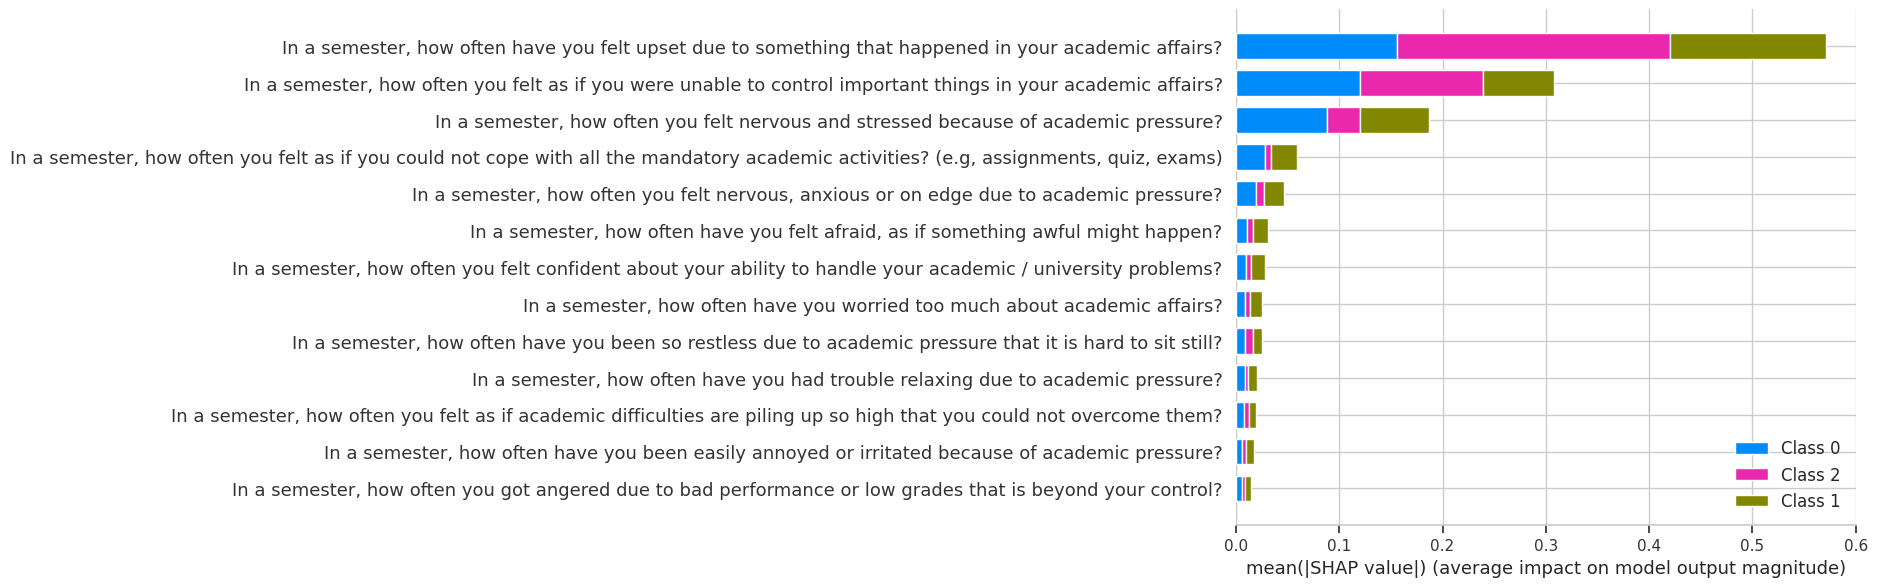


Generating SHAP explanation for: Anxiety_Level


/usr/local/lib/python3.11/dist-packages/shap/plots/_beeswarm.py:1153: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  pl.tight_layout()


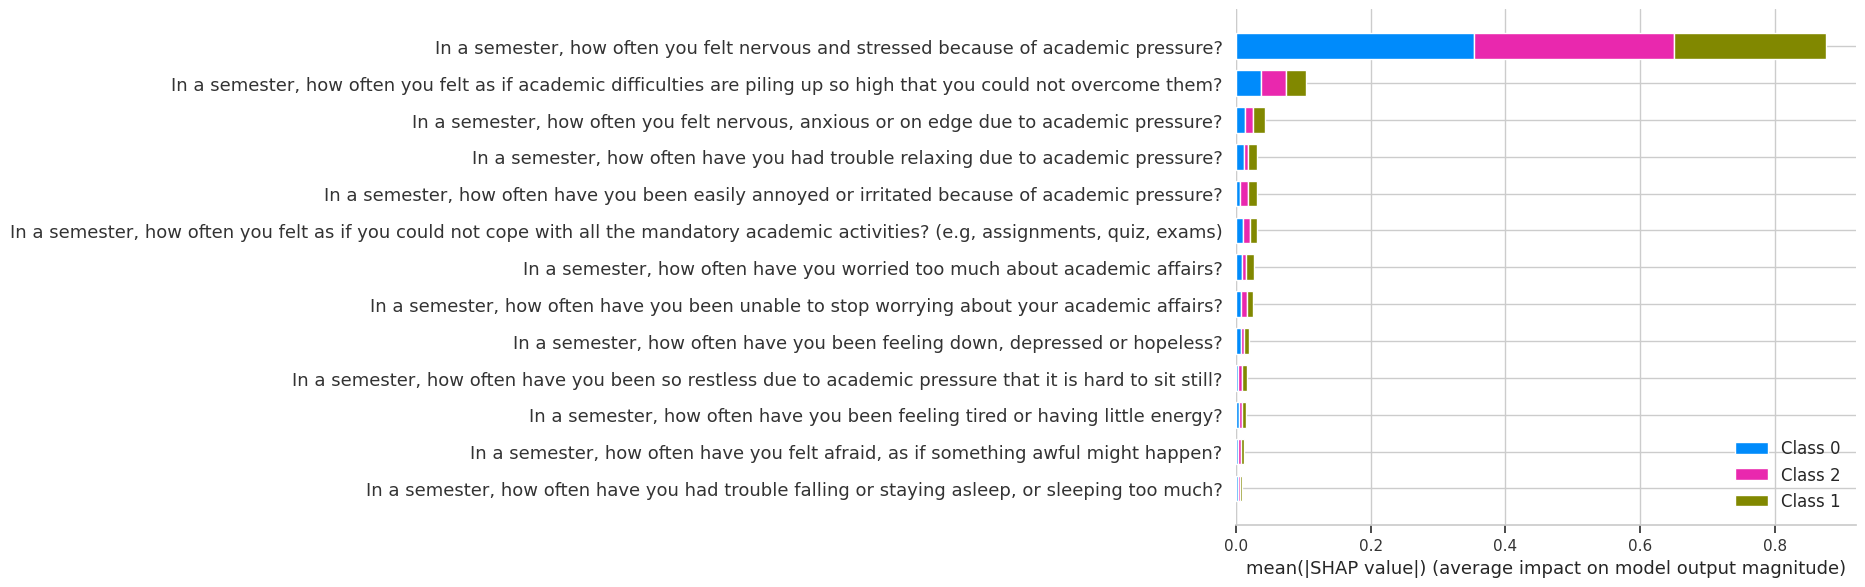


Generating SHAP explanation for: Depression_Level


 99%|===================| 298/300 [00:18<00:00]       /usr/local/lib/python3.11/dist-packages/shap/plots/_beeswarm.py:1153: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  pl.tight_layout()


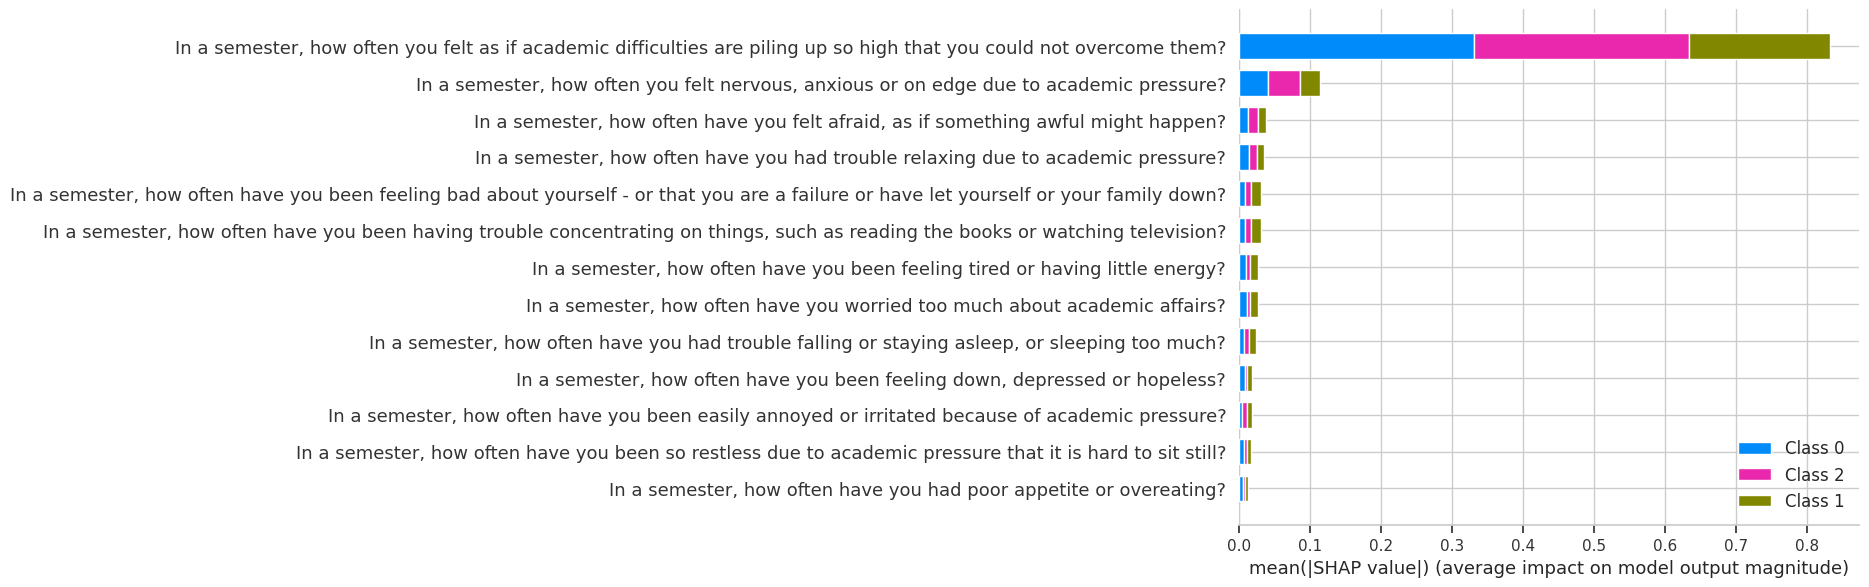

In [33]:
import shap

for label in y.columns:
    print(f"\nGenerating SHAP explanation for: {label}")

    model = joblib.load(f"models/cv_models/{label}_FinalModel.pkl")
    le = label_encoders[label]

    y_encoded = le.transform(y[label])

    selector = SelectKBest(f_classif, k=15)
    X_selected = selector.fit_transform(X, y_encoded)

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_selected)

    pca = PCA(n_components=0.95)
    X_pca = pca.fit_transform(X_scaled)

    smote = SMOTE(random_state=42)
    enn = EditedNearestNeighbours(n_neighbors=3)
    pipeline = Pipeline(steps=[('smote', smote), ('enn', enn)])

    X_resampled, y_resampled = pipeline.fit_resample(X_pca, y_encoded)

    X_train, X_val, y_train, y_val = train_test_split(
        X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

    # Create SHAP explainer for the model
    explainer = shap.Explainer(model, X_train)

    # Get SHAP values on a subset
    shap_values = explainer(X_val[:100])

    # Use PCA component names as features, since model input is after PCA
    feature_names = [f"PC{i}" for i in range(X_pca.shape[1])]
    shap.summary_plot(shap_values, X_val[:100], feature_names=selector.get_feature_names_out())


# Correlation (question mapping) Final

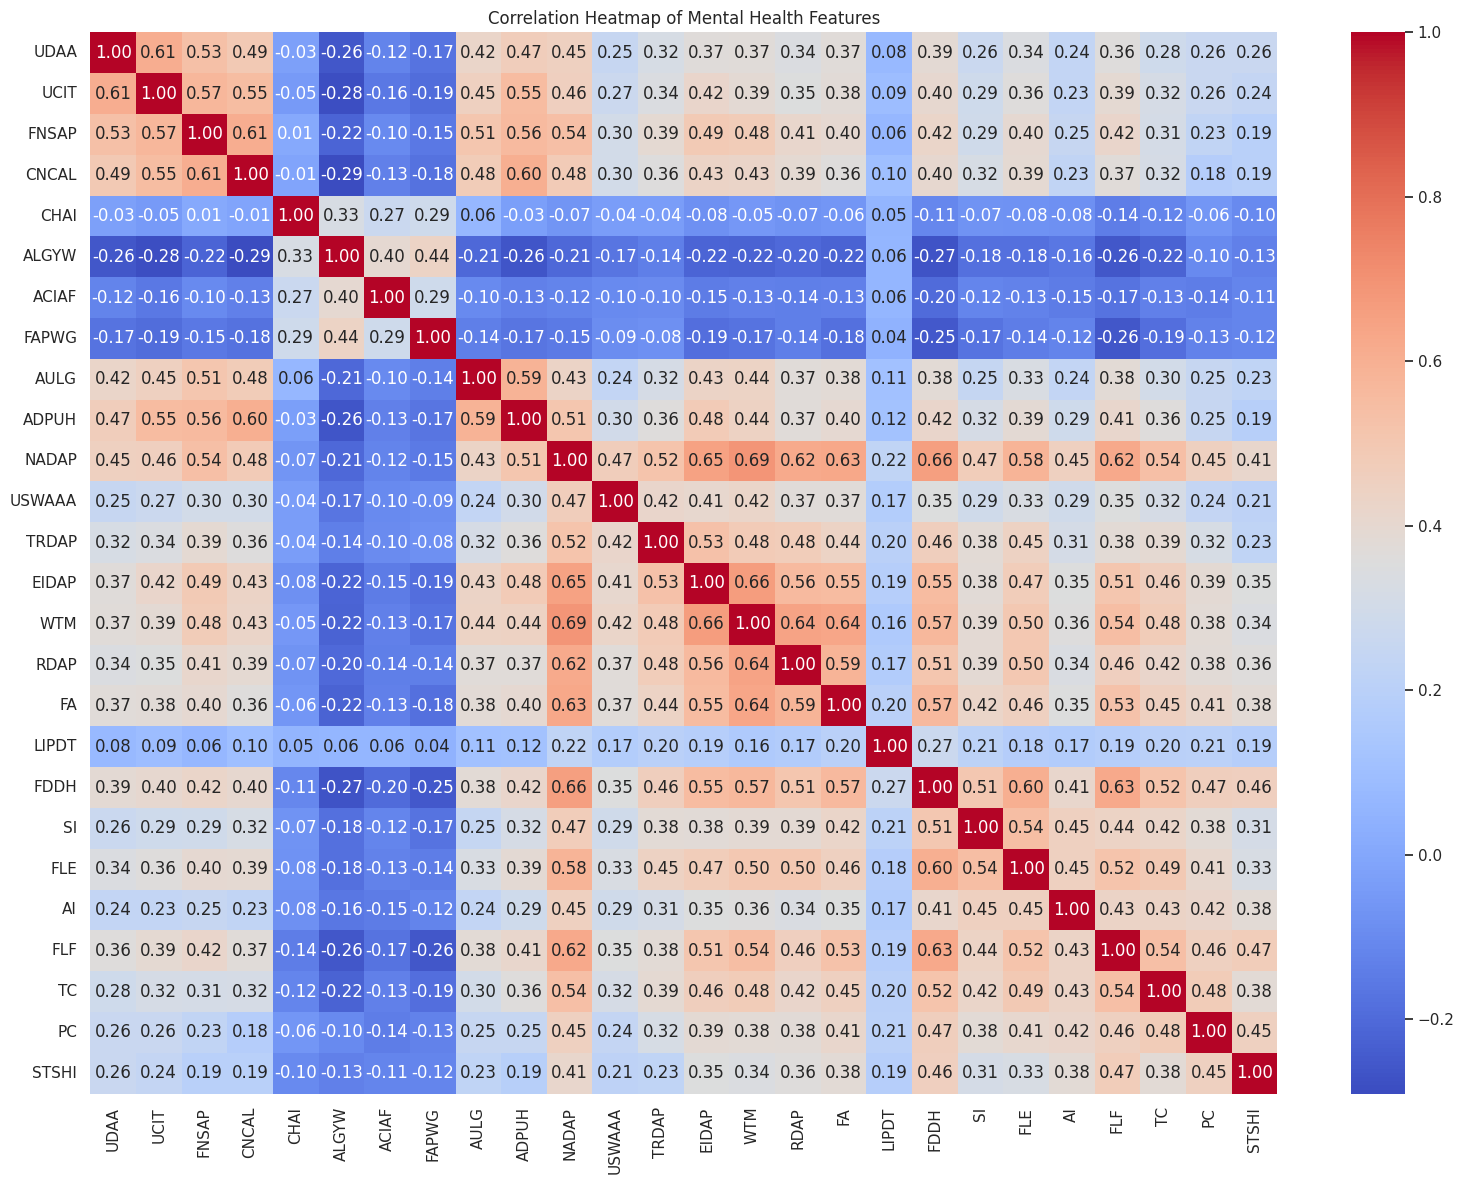


Dropped 0 highly correlated features:
[]


In [35]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer

df = pd.read_csv("/content/Raw Dataset.csv")
df.columns = [col.split(". ", 1)[-1].strip() for col in df.columns]

stress_cols = df.columns[7:17]
anxiety_cols = df.columns[17:24]
depression_cols = df.columns[24:33]
selected_cols = list(stress_cols) + list(anxiety_cols) + list(depression_cols)

question_mapping = {
    "UDAA": "Upset due to academic affairs",
    "UCIT": "Unable to control important things",
    "FNSAP": "Felt nervous and stressed academic pressure",
    "CNCAL": "Could not cope with academic load",
    "CHAI": "Confident handling academic issues",
    "ALGYW": "Academic life going your way",
    "ACIAF": "Able to Control Irritations in Academic Affairs ",
    "FAPWG": "Felt Academic Performance Was Good",
    "AULG": "Angered by Uncontrollable Low Grades",
    "ADPUH": "Academic Difficulties Piling Up so High",
    "NADAP": "Nervous/Anxious Due to Academic Pressure",
    "USWAAA": "Unable to Stop Worrying About Academic Affairs",
    "TRDAP": "Trouble Relaxing Due to Academic Pressure",
    "EIDAP": "Easily Irritated Due to Academic Pressure",
    "WTM": "Worried Too Much",
    "RDAP": "Restless Due to Academic Pressure",
    "FA": "Felt Afraid",
    "LIPDT": "Little Interest or Pleasure in Doing Things",
    "FDDH": "Felt Down, Depressed or Hopeless",
    "SI": "Sleep Issues",
    "FLE": "Fatigue or Low Energy",
    "AI": "Appetite Issues",
    "FLF": "Feeling Like a Failure",
    "TC": "Trouble Concentrating",
    "PC": "Psychomotor Changes",
    "STSHI": "Suicidal Thoughts or Self-harm Ideation"
}

# Create mapping to rename selected columns
alphabet_labels = list(question_mapping.keys())
column_rename_map = dict(zip(selected_cols, alphabet_labels))
df.rename(columns=column_rename_map, inplace=True)
selected_cols = alphabet_labels  # Update to new names

# Convert responses to numerical values
def convert_response(resp):
    mapping = {
        "0 - Never": 0, "1 - Almost Never": 1, "2 - Sometimes": 2,
        "3 - Fairly Often": 3, "4 - Very Often": 4,
        "0 - Not at all": 0, "1 - Several days": 1,
        "2 - More than half the days": 2, "3 - Nearly every day": 3
    }
    return mapping.get(resp, np.nan)

for col in selected_cols:
    df[col] = df[col].apply(convert_response)

imputer = KNNImputer(n_neighbors=5)
df[selected_cols] = imputer.fit_transform(df[selected_cols])

def remove_outliers(df, cols):
    Q1 = df[cols].quantile(0.25)
    Q3 = df[cols].quantile(0.75)
    IQR = Q3 - Q1
    return df[~((df[cols] < (Q1 - 1.5 * IQR)) | (df[cols] > (Q3 + 1.5 * IQR))).any(axis=1)]

df = remove_outliers(df, selected_cols)

corr_matrix = df[selected_cols].corr()

plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title("Correlation Heatmap of Mental Health Features")
plt.tight_layout()
plt.show()

# Drop highly correlated features (correlation > 0.9)
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column].abs() > 0.9)]

df_reduced = df.drop(columns=to_drop)

print(f"\nDropped {len(to_drop)} highly correlated features:")
print(to_drop)


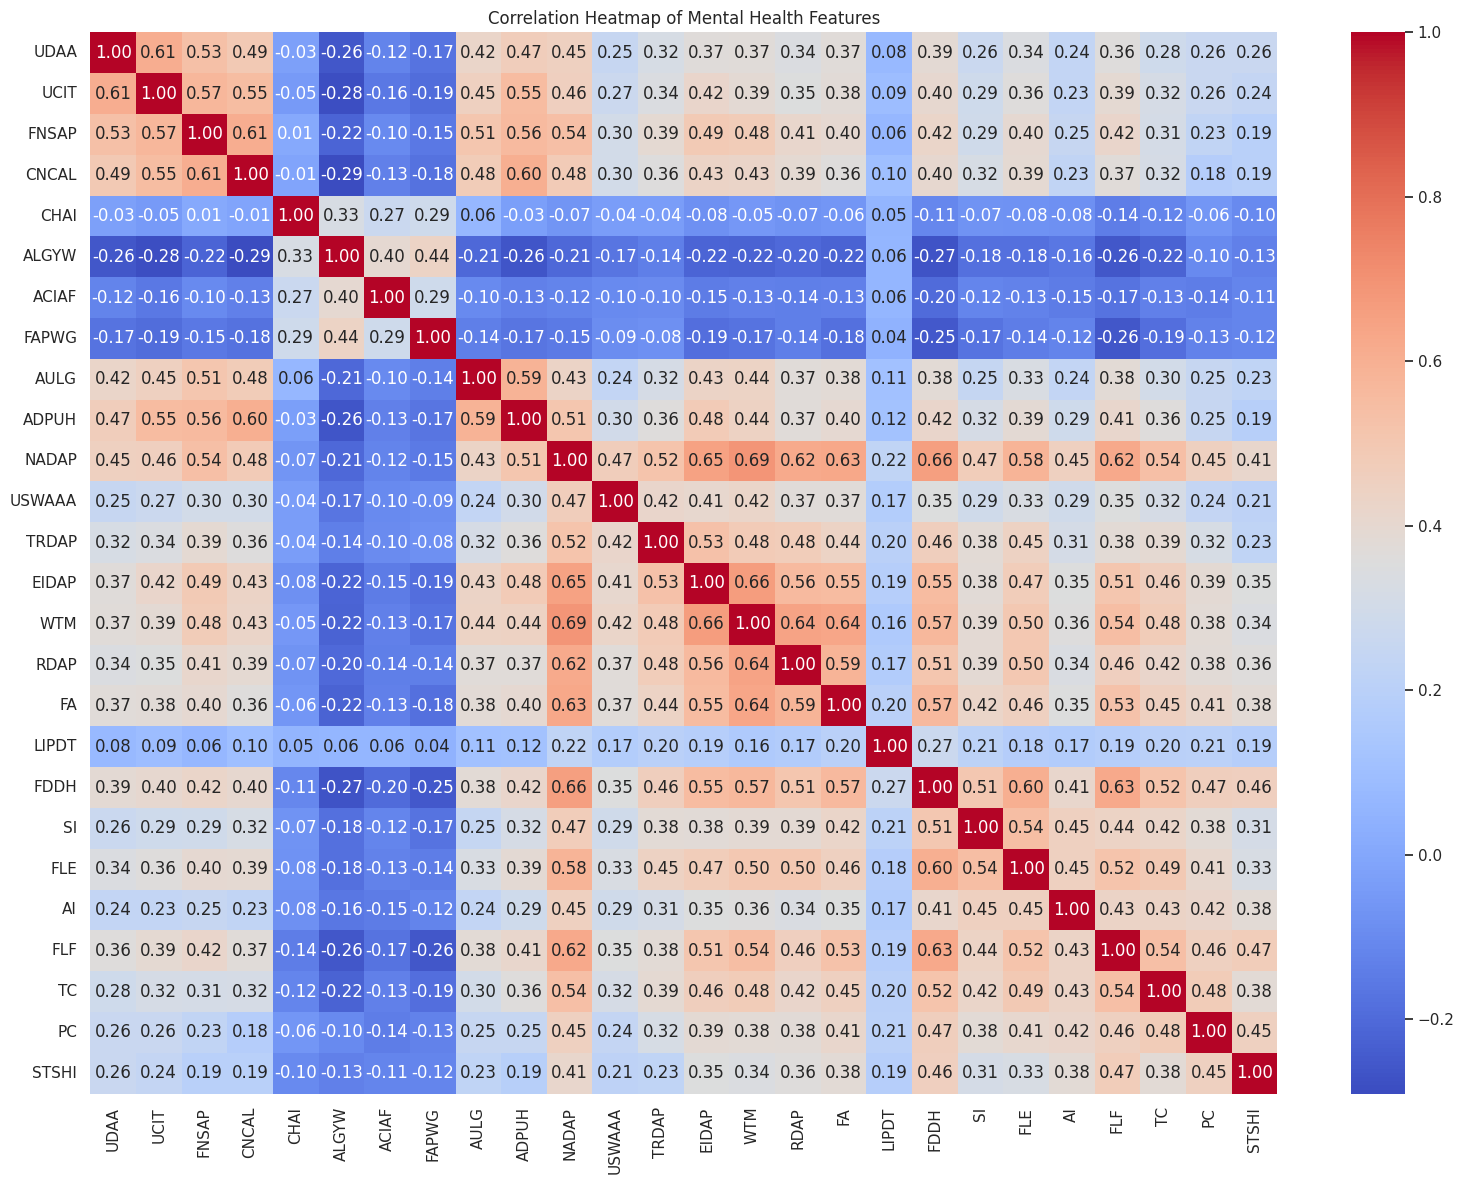


Dropped 0 highly correlated features:
[]


In [39]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer

df = pd.read_csv("/content/Raw Dataset.csv")
df.columns = [col.split(". ", 1)[-1].strip() for col in df.columns]

stress_cols = df.columns[7:17]
anxiety_cols = df.columns[17:24]
depression_cols = df.columns[24:33]
selected_cols = list(stress_cols) + list(anxiety_cols) + list(depression_cols)

question_mapping = {
    "UDAA": "In a semester, how often have you felt upset due to something that happened in your academic affairs?",
    "UCIT": "In a semester, how often you felt as if you were unable to control important things in your academic affairs?",
    "FNSAP": "In a semester, how often you felt nervous and stressed because of academic pressure?",
    "CNCAL": "In a semester, how often you felt as if you could not cope with all the mandatory academic activities? (e.g, assignments, quiz, exams)",
    "CHAI": "In a semester, how often you felt confident about your ability to handle your academic / university problems?",
    "ALGYW": "In a semester, how often you felt as if things in your academic life is going on your way?",
    "ACIAF": "In a semester, how often are you able to control irritations in your academic / university affairs?",
    "FAPWG": "In a semester, how often you felt as if your academic performance was on top?",
    "AULG": "In a semester, how often you got angered due to bad performance or low grades that is beyond your control?",
    "ADPUH": "In a semester, how often you felt as if academic difficulties are piling up so high that you could not overcome them?",
    "NADAP": "In a semester, how often you felt nervous, anxious or on edge due to academic pressure?",
    "USWAAA": "In a semester, how often have you been unable to stop worrying about your academic affairs?",
    "TRDAP": "In a semester, how often have you had trouble relaxing due to academic pressure?",
    "EIDAP": "In a semester, how often have you been easily annoyed or irritated because of academic pressure?",
    "WTM": "In a semester, how often have you worried too much about academic affairs?",
    "RDAP": "In a semester, how often have you been so restless due to academic pressure that it is hard to sit still?",
    "FA": "In a semester, how often have you felt afraid, as if something awful might happen?",
    "LIPDT": "In a semester, how often have you had little interest or pleasure in doing things?",
    "FDDH": "In a semester, how often have you been feeling down, depressed or hopeless?",
    "SI": "In a semester, how often have you had trouble falling or staying asleep, or sleeping too much?",
    "FLE": "In a semester, how often have you been feeling tired or having little energy?",
    "AI": "In a semester, how often have you had poor appetite or overeating?",
    "FLF": "In a semester, how often have you been feeling bad about yourself - or that you are a failure or have let yourself or your family down?",
    "TC": "In a semester, how often have you been having trouble concentrating on things, such as reading the books or watching television?",
    "PC": "In a semester, how often have you moved or spoke too slowly for other people to notice? Or you've been moving a lot more than usual because you've been restless?",
    "STSHI": "In a semester, how often have you had thoughts that you would be better off dead, or of hurting yourself?"
}

alphabet_labels = list(question_mapping.keys())
column_rename_map = dict(zip(selected_cols, alphabet_labels))
df.rename(columns=column_rename_map, inplace=True)
selected_cols = alphabet_labels

def convert_response(resp):
    mapping = {
        "0 - Never": 0, "1 - Almost Never": 1, "2 - Sometimes": 2,
        "3 - Fairly Often": 3, "4 - Very Often": 4,
        "0 - Not at all": 0, "1 - Several days": 1,
        "2 - More than half the days": 2, "3 - Nearly every day": 3
    }
    return mapping.get(resp, np.nan)

for col in selected_cols:
    df[col] = df[col].apply(convert_response)

imputer = KNNImputer(n_neighbors=5)
df[selected_cols] = imputer.fit_transform(df[selected_cols])

def remove_outliers(df, cols):
    Q1 = df[cols].quantile(0.25)
    Q3 = df[cols].quantile(0.75)
    IQR = Q3 - Q1
    return df[~((df[cols] < (Q1 - 1.5 * IQR)) | (df[cols] > (Q3 + 1.5 * IQR))).any(axis=1)]

df = remove_outliers(df, selected_cols)

corr_matrix = df[selected_cols].corr()

plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title("Correlation Heatmap of Mental Health Features")
plt.tight_layout()
plt.show()

# Drop highly correlated features (correlation > 0.9)
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column].abs() > 0.9)]

df_reduced = df.drop(columns=to_drop)

print(f"\nDropped {len(to_drop)} highly correlated features:")
print(to_drop)


# Random Forest feature importance (Number %) (question mapping)

<ipython-input-58-6b64b56aa842>:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Stress_Score"] = df[stress_cols].sum(axis=1)
<ipython-input-58-6b64b56aa842>:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Anxiety_Score"] = df[anxiety_cols].sum(axis=1)
<ipython-input-58-6b64b56aa842>:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

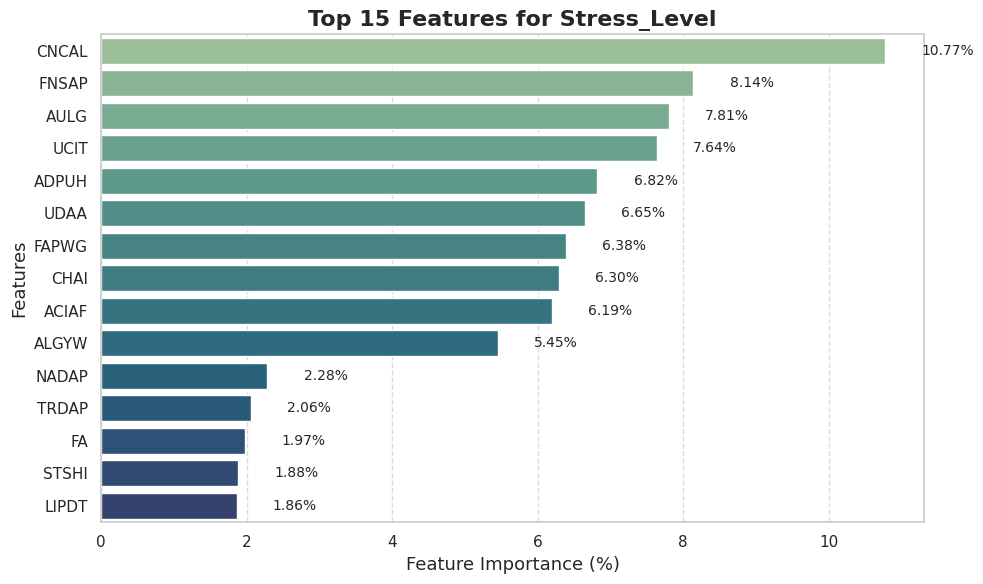

<ipython-input-58-6b64b56aa842>:120: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


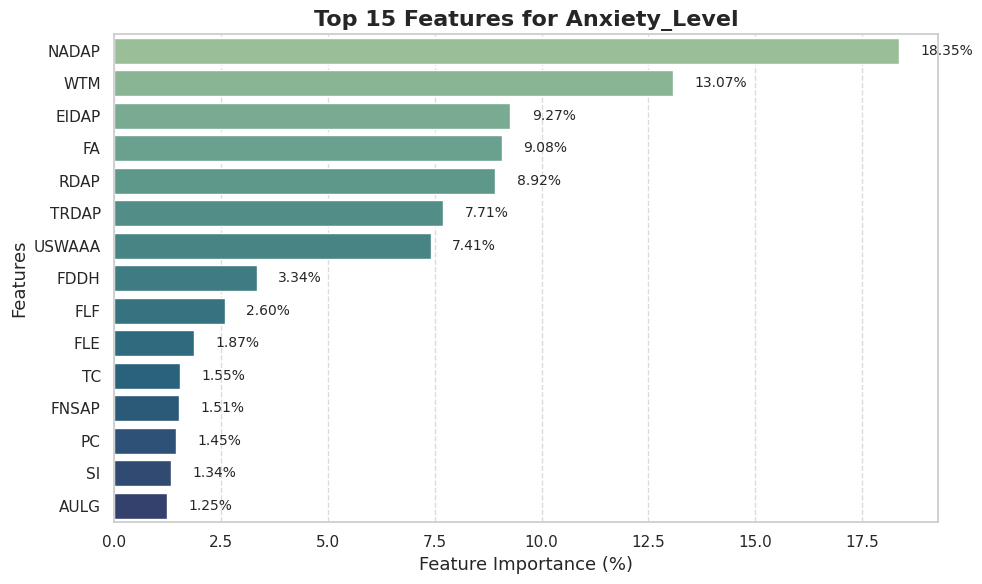

<ipython-input-58-6b64b56aa842>:120: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


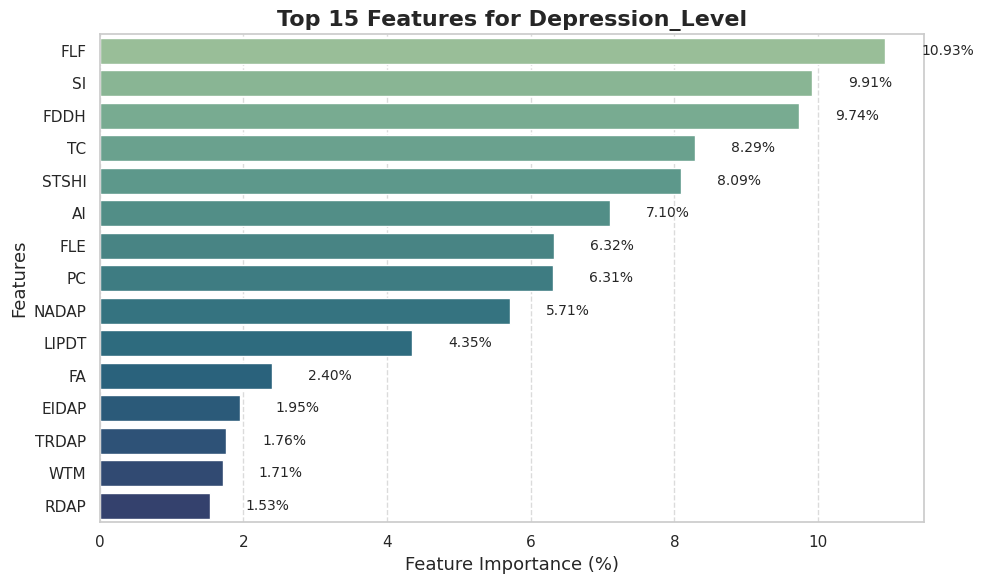

In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier

sns.set(style="whitegrid")


df = pd.read_csv("/content/Raw Dataset.csv")
df.columns = [col.split(". ", 1)[-1].strip() for col in df.columns]

question_mapping = {
    "In a semester, how often have you felt upset due to something that happened in your academic affairs?": "UDAA",
    "In a semester, how often you felt as if you were unable to control important things in your academic affairs?": "UCIT",
    "In a semester, how often you felt nervous and stressed because of academic pressure?": "FNSAP",
    "In a semester, how often you felt as if you could not cope with all the mandatory academic activities? (e.g, assignments, quiz, exams)": "CNCAL",
    "In a semester, how often you felt confident about your ability to handle your academic / university problems?": "CHAI",
    "In a semester, how often you felt as if things in your academic life is going on your way?": "ALGYW",
    "In a semester, how often are you able to control irritations in your academic / university affairs?": "ACIAF",
    "In a semester, how often you felt as if your academic performance was on top?": "FAPWG",
    "In a semester, how often you got angered due to bad performance or low grades that is beyond your control?": "AULG",
    "In a semester, how often you felt as if academic difficulties are piling up so high that you could not overcome them?": "ADPUH",
    "In a semester, how often you felt nervous, anxious or on edge due to academic pressure?": "NADAP",
    "In a semester, how often have you been unable to stop worrying about your academic affairs?": "USWAAA",
    "In a semester, how often have you had trouble relaxing due to academic pressure?": "TRDAP",
    "In a semester, how often have you been easily annoyed or irritated because of academic pressure?": "EIDAP",
    "In a semester, how often have you worried too much about academic affairs?": "WTM",
    "In a semester, how often have you been so restless due to academic pressure that it is hard to sit still?": "RDAP",
    "In a semester, how often have you felt afraid, as if something awful might happen?": "FA",
    "In a semester, how often have you had little interest or pleasure in doing things?": "LIPDT",
    "In a semester, how often have you been feeling down, depressed or hopeless?": "FDDH",
    "In a semester, how often have you had trouble falling or staying asleep, or sleeping too much?": "SI",
    "In a semester, how often have you been feeling tired or having little energy?": "FLE",
    "In a semester, how often have you had poor appetite or overeating?": "AI",
    "In a semester, how often have you been feeling bad about yourself - or that you are a failure or have let yourself or your family down?": "FLF",
    "In a semester, how often have you been having trouble concentrating on things, such as reading the books or watching television?": "TC",
    "In a semester, how often have you moved or spoke too slowly for other people to notice? Or you've been moving a lot more than usual because you've been restless?": "PC",
    "In a semester, how often have you had thoughts that you would be better off dead, or of hurting yourself?": "STSHI"
}

df.rename(columns=question_mapping, inplace=True)


stress_cols = df.columns[7:17]
anxiety_cols = df.columns[17:24]
depression_cols = df.columns[24:33]
selected_cols = list(stress_cols) + list(anxiety_cols) + list(depression_cols)


def convert_response(resp):
    mapping = {
        "0 - Never": 0, "1 - Almost Never": 1, "2 - Sometimes": 2,
        "3 - Fairly Often": 3, "4 - Very Often": 4,
        "0 - Not at all": 0, "1 - Several days": 1,
        "2 - More than half the days": 2, "3 - Nearly every day": 3
    }
    return mapping.get(resp, np.nan)

for col in selected_cols:
    df[col] = df[col].apply(convert_response)


imputer = KNNImputer(n_neighbors=5)
df[selected_cols] = imputer.fit_transform(df[selected_cols])


def remove_outliers(df, cols):
    Q1 = df[cols].quantile(0.25)
    Q3 = df[cols].quantile(0.75)
    IQR = Q3 - Q1
    return df[~((df[cols] < (Q1 - 1.5 * IQR)) | (df[cols] > (Q3 + 1.5 * IQR))).any(axis=1)]

df = remove_outliers(df, selected_cols)

df["Stress_Score"] = df[stress_cols].sum(axis=1)
df["Anxiety_Score"] = df[anxiety_cols].sum(axis=1)
df["Depression_Score"] = df[depression_cols].sum(axis=1)

def classify(score, mild, moderate):
    if score <= mild:
        return "Low"
    elif score <= moderate:
        return "Moderate"
    else:
        return "Severe"

df["Stress_Level"] = df["Stress_Score"].apply(lambda x: classify(x, 13, 26))
df["Anxiety_Level"] = df["Anxiety_Score"].apply(lambda x: classify(x, 7, 14))
df["Depression_Level"] = df["Depression_Score"].apply(lambda x: classify(x, 9, 18))

X = df[selected_cols]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
feature_names = selected_cols

for label in ["Stress_Level", "Anxiety_Level", "Depression_Level"]:
    y = df[label]
    y_encoded = LabelEncoder().fit_transform(y)

    # Train Random Forest
    rf = RandomForestClassifier(n_estimators=200, random_state=42)
    rf.fit(X_scaled, y_encoded)

    # Calculate importance
    importances = rf.feature_importances_
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)

    importance_df['Importance (%)'] = 100 * importance_df['Importance'] / importance_df['Importance'].sum()
    top_n = 15
    top_features = importance_df.head(top_n)


    plt.figure(figsize=(10, 6))
    ax = sns.barplot(
        data=top_features,
        y='Feature',
        x='Importance (%)',
        palette='crest'
    )
    for i, val in enumerate(top_features['Importance (%)']):
        ax.text(val + 0.5, i, f"{val:.2f}%", va='center', fontsize=10)

    plt.title(f"Top {top_n} Features for {label}", fontsize=16, weight='bold')
    plt.xlabel("Feature Importance (%)", fontsize=13)
    plt.ylabel("Features", fontsize=13)
    plt.grid(True, axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig(f"{label}_feature_importance_shortcode.png", dpi=300)
    plt.show()


# LIME (question mapping)

In [65]:
import pandas as pd
import numpy as np
import os
import joblib
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import KNNImputer
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.decomposition import PCA
from sklearn.metrics import roc_curve, auc
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
import lime
import lime.lime_tabular
import warnings

warnings.filterwarnings("ignore")

df = pd.read_csv("/content/Raw Dataset.csv")
df.columns = [col.split(". ", 1)[-1].strip() for col in df.columns]

stress_cols = df.columns[7:17]
anxiety_cols = df.columns[17:24]
depression_cols = df.columns[24:33]
selected_cols = list(stress_cols) + list(anxiety_cols) + list(depression_cols)


def convert_response(resp):
    mapping = {
        "0 - Never": 0, "1 - Almost Never": 1, "2 - Sometimes": 2,
        "3 - Fairly Often": 3, "4 - Very Often": 4,
        "0 - Not at all": 0, "1 - Several days": 1,
        "2 - More than half the days": 2, "3 - Nearly every day": 3
    }
    return mapping.get(resp, np.nan)

for col in selected_cols:
    df[col] = df[col].apply(convert_response)

imputer = KNNImputer(n_neighbors=5)
df[selected_cols] = imputer.fit_transform(df[selected_cols])


def remove_outliers(df, cols):
    Q1 = df[cols].quantile(0.25)
    Q3 = df[cols].quantile(0.75)
    IQR = Q3 - Q1
    return df[~((df[cols] < (Q1 - 1.5 * IQR)) | (df[cols] > (Q3 + 1.5 * IQR))).any(axis=1)]

df = remove_outliers(df, selected_cols)


df["Stress_Score"] = df[stress_cols].sum(axis=1)
df["Anxiety_Score"] = df[anxiety_cols].sum(axis=1)
df["Depression_Score"] = df[depression_cols].sum(axis=1)


def classify(score, mild, moderate):
    if score <= mild: return "Low"
    elif score <= moderate: return "Moderate"
    else: return "Severe"

df["Stress_Level"] = df["Stress_Score"].apply(lambda x: classify(x, 13, 26))
df["Anxiety_Level"] = df["Anxiety_Score"].apply(lambda x: classify(x, 7, 14))
df["Depression_Level"] = df["Depression_Score"].apply(lambda x: classify(x, 9, 18))

X = df[selected_cols].copy()
y = df[["Stress_Level", "Anxiety_Level", "Depression_Level"]].copy()

# Drop highly correlated features (>0.9)
corr_matrix = X.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [col for col in upper.columns if any(upper[col] > 0.9)]
X.drop(columns=to_drop, inplace=True)


os.makedirs("models/cv_models", exist_ok=True)

label_encoders = {label: LabelEncoder().fit(y[label]) for label in y.columns}

for label in y.columns:
    print(f"\nProcessing target: {label}")

    le = label_encoders[label]
    y_encoded = le.transform(y[label])

    # Feature selection
    selector = SelectKBest(f_classif, k=15)
    X_selected = selector.fit_transform(X, y_encoded)
    selected_feature_indices = selector.get_support(indices=True)
    selected_feature_names = X.columns[selected_feature_indices].tolist()

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_selected)

    pca = PCA(n_components=0.95)
    X_pca = pca.fit_transform(X_scaled)

    # Resampling
    smote = SMOTE(random_state=42)
    enn = EditedNearestNeighbours(n_neighbors=3)
    resampling_pipeline = Pipeline(steps=[('smote', smote), ('enn', enn)])
    X_resampled, y_resampled = resampling_pipeline.fit_resample(X_pca, y_encoded)

    X_train, X_val, y_train, y_val = train_test_split(
        X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

    # Grid search for RandomForest hyperparameters
    param_grid_rf = {
        'n_estimators': [100, 200],
        'max_depth': [None, 10],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2]
    }
    grid_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_rf, cv=3, n_jobs=-1, verbose=1)
    grid_rf.fit(X_train, y_train)
    best_rf = grid_rf.best_estimator_

    # Train MLPClassifier for comparison
    mlp = MLPClassifier(hidden_layer_sizes=(256, 128, 64), max_iter=500, random_state=42)
    mlp.fit(X_train, y_train)

    # Compute ROC AUC on validation set
    y_prob = mlp.predict_proba(X_val)
    fpr, tpr, _ = roc_curve(y_val, y_prob[:, 1], pos_label=1)
    print(f"MLP AUC for {label}: {auc(fpr, tpr):.2f}")

    # Save model
    joblib.dump(best_rf, f"models/cv_models/{label}_FinalModel.pkl")

    # LIME Explanation
    print(f"\nGenerating LIME explanation for: {label}")

    explainer = lime.lime_tabular.LimeTabularExplainer(
        X_train, feature_names=selected_feature_names, class_names=le.classes_, discretize_continuous=True
    )

    # Explain the first instance in validation set
    exp = explainer.explain_instance(X_val[0], best_rf.predict_proba, num_features=10)
    exp.show_in_notebook(show_table=True)


Output hidden; open in https://colab.research.google.com to view.

# SHAP (question mapping)


Generating SHAP explanation for: Stress_Level


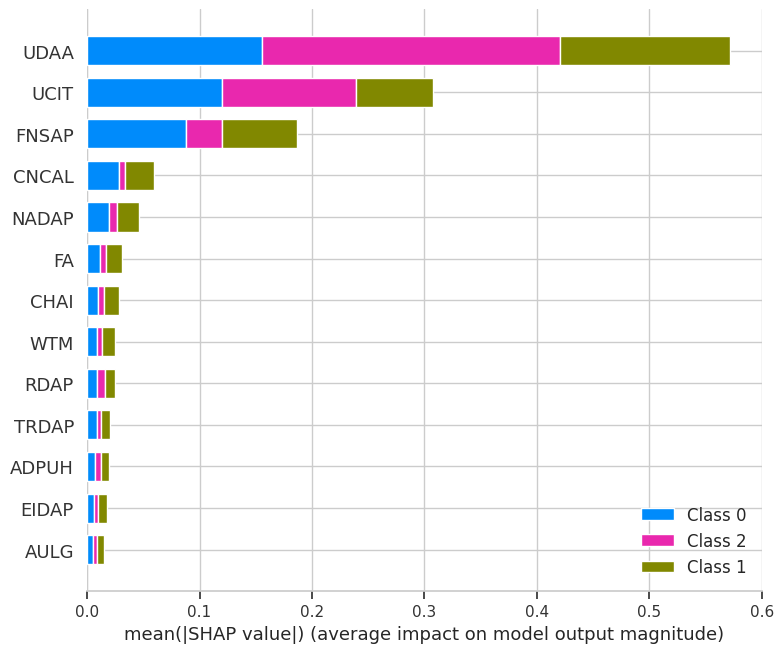


Generating SHAP explanation for: Anxiety_Level


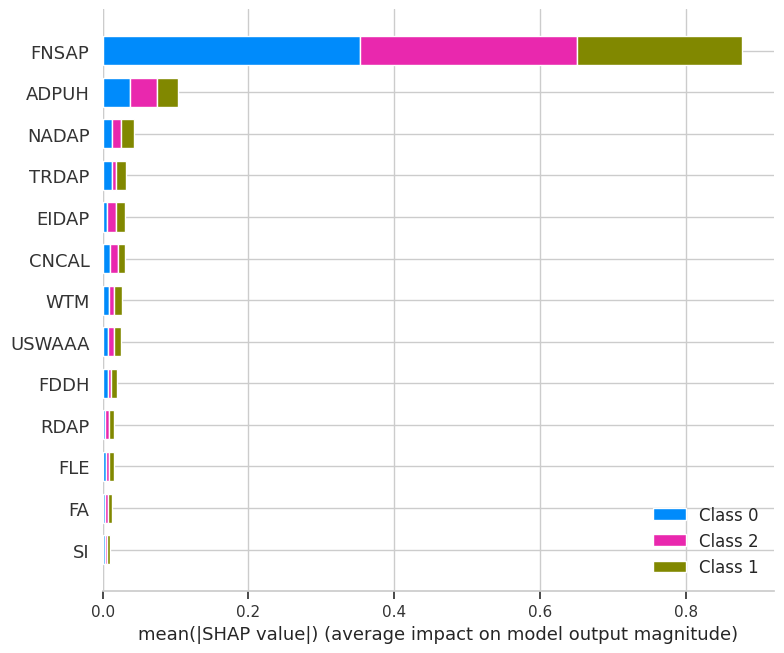


Generating SHAP explanation for: Depression_Level


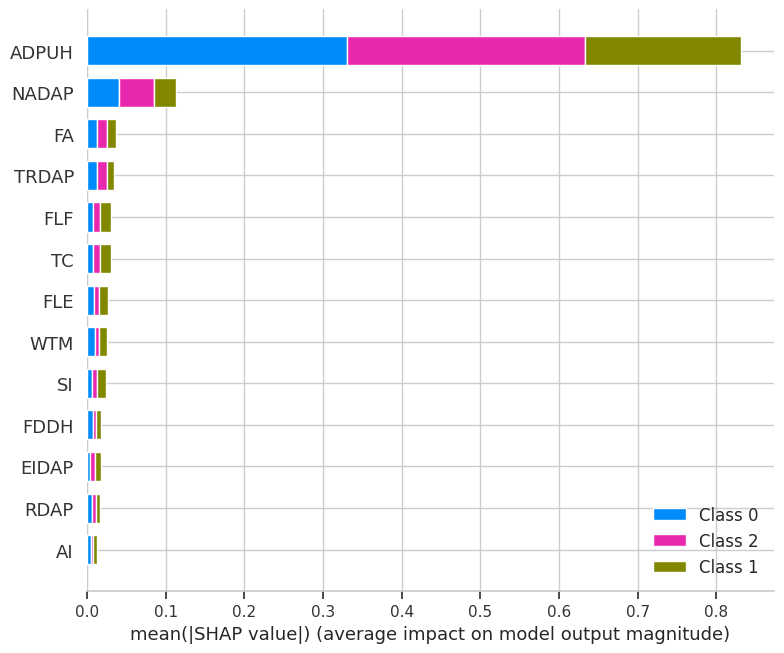

In [66]:
import shap

for label in y.columns:
    print(f"\nGenerating SHAP explanation for: {label}")

    model = joblib.load(f"models/cv_models/{label}_FinalModel.pkl")
    le = label_encoders[label]

    y_encoded = le.transform(y[label])

    selector = SelectKBest(f_classif, k=15)
    X_selected = selector.fit_transform(X, y_encoded)

    selected_features = selector.get_support(indices=True)
    original_feature_names = X.columns[selected_features]
    short_feature_names = [question_mapping.get(name, name) for name in original_feature_names]

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_selected)

    pca = PCA(n_components=0.95)
    X_pca = pca.fit_transform(X_scaled)

    smote = SMOTE(random_state=42)
    enn = EditedNearestNeighbours(n_neighbors=3)
    pipeline = Pipeline(steps=[('smote', smote), ('enn', enn)])
    X_resampled, y_resampled = pipeline.fit_resample(X_pca, y_encoded)

    X_train, X_val, y_train, y_val = train_test_split(
        X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

    # SHAP explainer on PCA-transformed data
    explainer = shap.Explainer(model, X_train)

    # Compute SHAP values
    shap_values = explainer(X_val[:100])

    n_components = X_train.shape[1]
    display_names = short_feature_names[:n_components]

    shap.summary_plot(shap_values, X_val[:100], feature_names=display_names)
